### Testy clippingu, clipping stosuje przy ujemnych krzywiznach, wartosc clippingu oraz batch size testuje eksperymentalnie

In [1]:
import os

os.chdir("..")

### Uruchamianie pojedynczego eksperymentu

In module products __package__, __name__ == tests tests.main


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Clipping_Comparison/original_logic exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


In module products __package__, __name__ == tests tests.trainloop
--- Uruchamianie 2 eksperymentów ---

[1/2] Uruchamianie: original_logic
Epoch 24: 100%|██████████| 430/430 [00:08<00:00, 52.94it/s, v_num=ogic]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 105.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.95999908447266
        test_loss           0.05756024271249771
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[2/2] Uruchamianie: hybrid_clipping_logic


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 430/430 [00:08<00:00, 50.67it/s, v_num=ogic]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 113.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.94000244140625
        test_loss           0.05397620424628258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Wszystkie eksperymenty zakończone ---

--- Generowanie wykresu porównawczego ---
Ostrzeżenie: Nie znaleziono logów dla original_logic, pomijam.
Ostrzeżenie: Nie znaleziono logów dla hybrid_clipping_logic, pomijam.


/tmp/ipykernel_44298/1882812167.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Wykres porównawczy zapisano w: logs/dOGR_Clipping_Comparison/comparison_plot.png


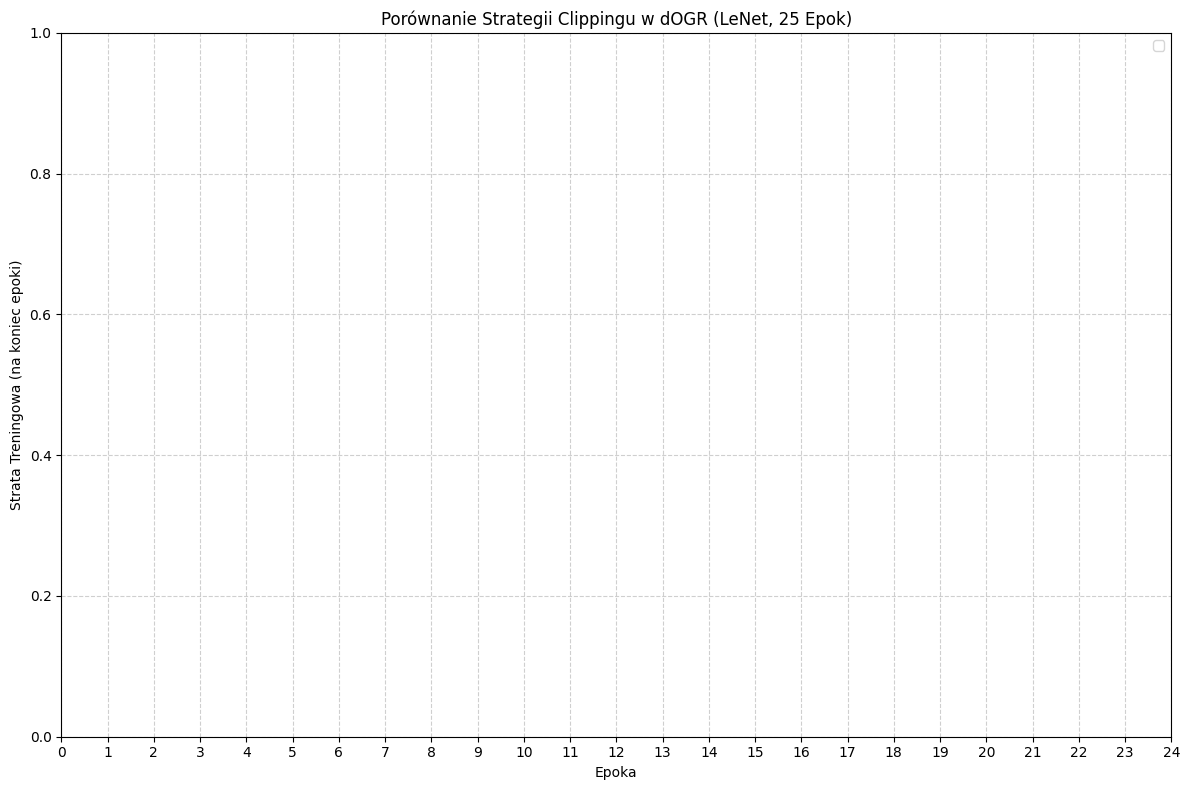

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Clipping_Comparison"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
BATCH_SIZE = 128
NET = "LeNet"

experiments = {
    "original_logic": {
        "opt": dOGR,
        "args": {"lr": 1e-3, "linear_clipping": False}
    },
    "linear_clipping_logic": {
        "opt": dOGR,
        "args": {"lr": 1e-3, "linear_clipping": True, "neg_clip_val": 10.0}
    },
}

def run_comparison():
    """Uruchamia oba zdefiniowane eksperymenty."""
    print(f"--- Uruchamianie {len(experiments)} eksperymentów ---")
    for i, (version_name, config) in enumerate(experiments.items()):
        print(f"\n[{i+1}/{len(experiments)}] Uruchamianie: {version_name}")
        
        net = net_dict[NET]()
        optimizer = config["opt"](net.parameters(), **config["args"])
        
        run(
            net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
            version=version_name, max_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE
        )
    print("\n--- Wszystkie eksperymenty zakończone ---")

if __name__ == "__main__":
    run_comparison()


--- Generowanie wykresu porównawczego ---
Wykres porównawczy zapisano w: logs/dOGR_Clipping_Comparison/comparison_plot.png


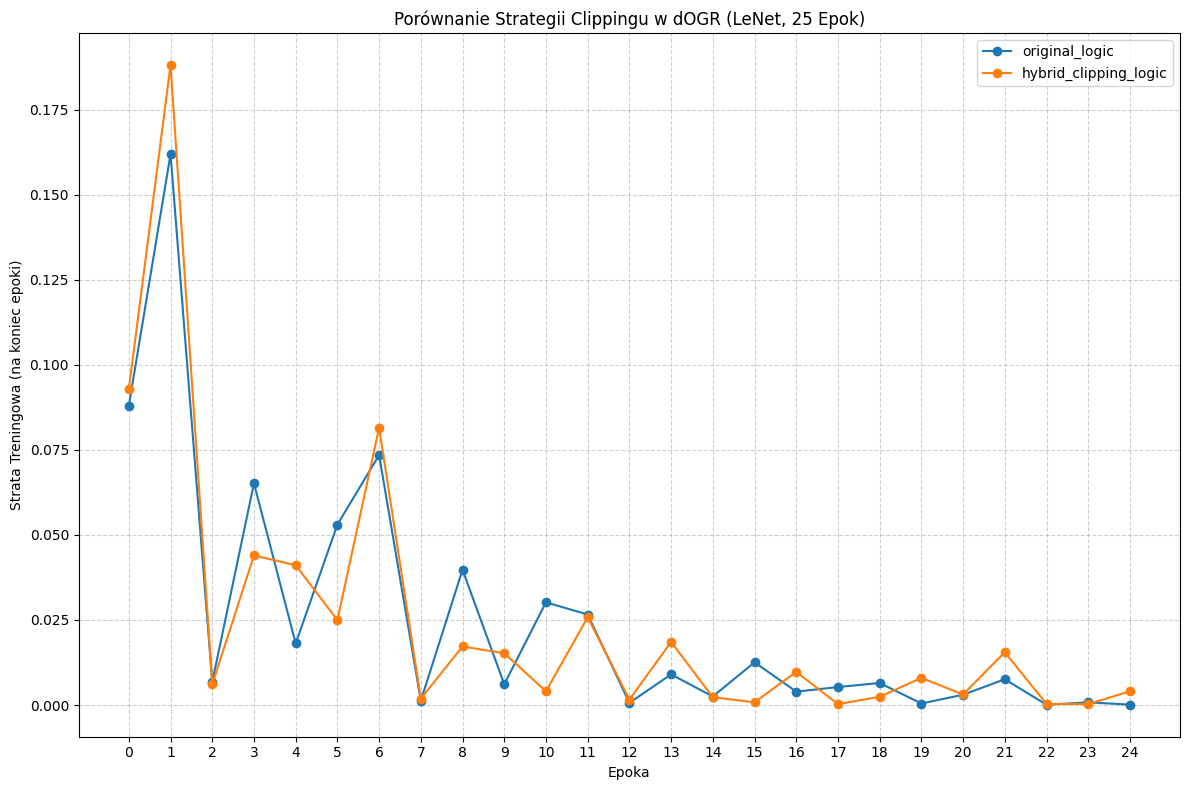

In [7]:
def plot_comparison():
    """Generuje wykres porównawczy dla obu strategii."""
    print("\n--- Generowanie wykresu porównawczego ---")
    plt.figure(figsize=(12, 8))
    
    for version_name in experiments.keys():
        path = LOGGING_DIR / EXPERIMENT_NAME / f"{version_name}" / "metrics.csv"
        if not path.exists():
            print(f"Ostrzeżenie: Nie znaleziono logów dla {version_name}, pomijam.")
            continue
            
        df = pd.read_csv(path)
        train_loss_df = df[["epoch", "train_loss"]].dropna().groupby("epoch").last().reset_index()

        plt.plot(train_loss_df["epoch"], train_loss_df["train_loss"], "o-", label=version_name)

    plt.title(f"Porównanie Strategii Clippingu w dOGR ({NET}, {MAX_EPOCHS} Epok)")
    plt.xlabel("Epoka")
    plt.ylabel("Strata Treningowa (na koniec epoki)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xticks(range(MAX_EPOCHS))
    plt.tight_layout()
    
    plot_path = LOGGING_DIR / EXPERIMENT_NAME / "comparison_plot.png"
    plt.savefig(plot_path)
    print(f"Wykres porównawczy zapisano w: {plot_path}")
    plt.show()

if __name__ == "__main__":
    plot_comparison()

### Uruchomienie eksperymentow z siatka mozliwych parametrow clipping_val i batch_size zeby odkryc ktora kombinacja jest najlepsza

In [2]:
import os

os.chdir("..")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import itertools
import numpy as np

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Grid_Search"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
NET = "LeNet"
LEARNING_RATE = 1e-3

# Siatka parametrow do przeszukania
param_grid = {
    'batch_size': [1, 4, 8, 16, 32, 64],
    'neg_clip_val': np.logspace(np.log10(5), np.log10(100), 5, dtype=int).tolist() 
}

experiments = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
BATCH_SIZES = param_grid['batch_size']
CLIPPING_VALUES = param_grid['neg_clip_val']

experiments = []
keys, values = zip(*param_grid.items())
for v in itertools.product(*values):
    experiments.append(dict(zip(keys, v)))

def run_all_experiments():
    """Uruchamia serię eksperymentów dla każdej kombinacji parametrów."""
    total_experiments = len(experiments)
    print(f"--- Uruchamianie {total_experiments} eksperymentów (Grid Search) ---")
    
    for i, config in enumerate(experiments):
        batch_size = config['batch_size']
        clip_val = config['neg_clip_val']
        
        clip_str = f"clip_{clip_val}" if clip_val is not None else "no_clip"
        version_name = f"bs_{batch_size}_{clip_str}"
        
        print(f"\n[{i+1}/{total_experiments}] Uruchamianie: {version_name}")
        
        torch.manual_seed(42)
        net = net_dict[NET]()
        
        optimizer = dOGR(
            net.parameters(), 
            lr=LEARNING_RATE, 
            linear_clipping=True, 
            neg_clip_val=clip_val
        )
        
        try:
            run(
                net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
                version=version_name, max_epochs=MAX_EPOCHS, batch_size=batch_size
            )
        except Exception as e:
            print(f"Błąd podczas eksperymentu z config = {config}: {e}")
            print("Pominięto ten przebieg.")

    print("\n--- Wszystkie eksperymenty zakończone ---")

if __name__ == "__main__":
    run_all_experiments()

In module products __package__, __name__ == tests tests.main


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In module products __package__, __name__ == tests tests.trainloop
--- Uruchamianie 5 eksperymentów (Grid Search) ---

[1/5] Uruchamianie: bs_64_clip_5



  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 57.77it/s, v_num=ip_5]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 57.71it/s, v_num=ip_5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 107.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.94999694824219
        test_loss           0.08223270624876022
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[2/5] Uruchamianie: bs_64_clip_10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:15<00:00, 56.09it/s, v_num=p_10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:15<00:00, 56.02it/s, v_num=p_10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 125.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.95999908447266
        test_loss           0.07529051601886749
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[3/5] Uruchamianie: bs_64_clip_22


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 62.86it/s, v_num=p_22]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 62.79it/s, v_num=p_22]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 146.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.06839779019355774
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[4/5] Uruchamianie: bs_64_clip_47


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 58.24it/s, v_num=p_47]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 58.17it/s, v_num=p_47]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 126.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.87000274658203
        test_loss           0.06391171365976334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[5/5] Uruchamianie: bs_64_clip_100


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.00it/s, v_num=_100]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.92it/s, v_num=_100]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 144.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.79000091552734
        test_loss           0.06443191319704056
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Wszystkie eksperymenty zakończone ---



--- Generowanie osobnych wykresów dla każdego batch size ---
logs/dOGR_Grid_Search/bs_1_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_1_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_1_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_1_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_1_clip_100/metrics.csv
Wykres dla batch_size=1 zapisano w: logs/dOGR_Grid_Search/comparison_bs_1.png


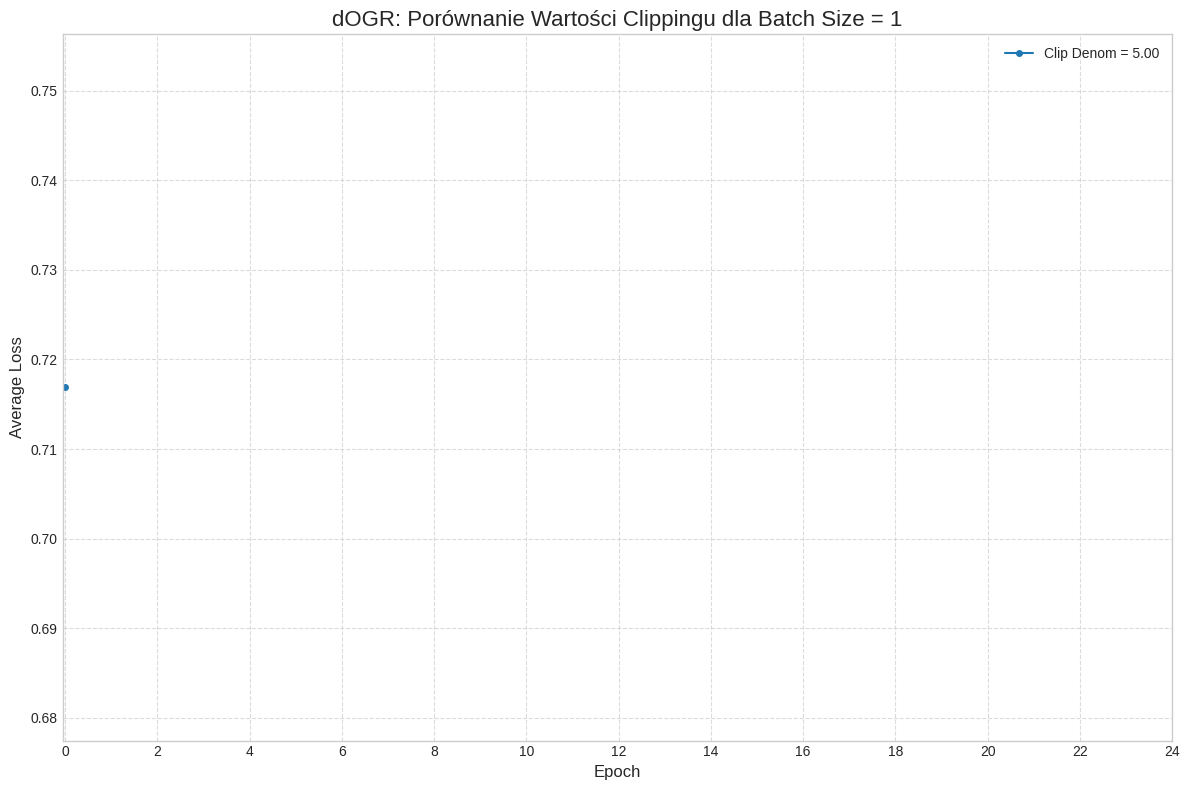

logs/dOGR_Grid_Search/bs_4_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_4_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_4_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_4_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_4_clip_100/metrics.csv
Wykres dla batch_size=4 zapisano w: logs/dOGR_Grid_Search/comparison_bs_4.png


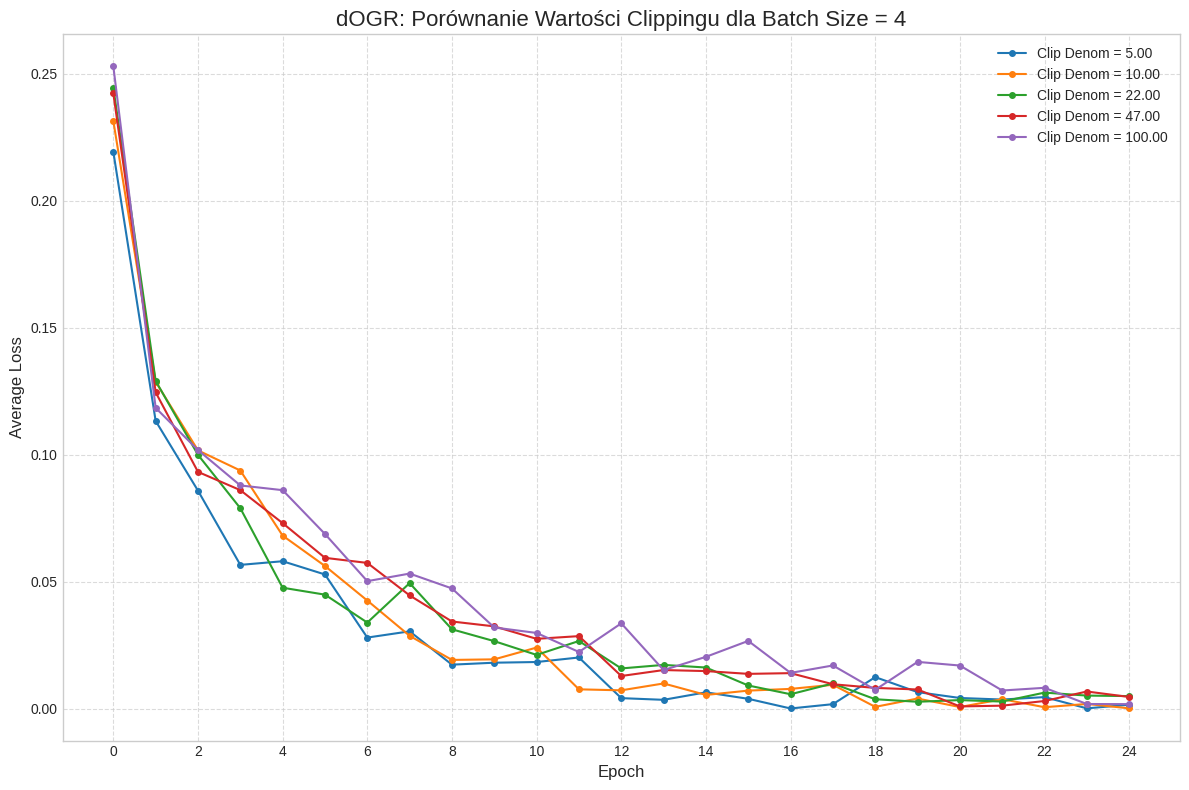

logs/dOGR_Grid_Search/bs_8_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_8_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_8_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_8_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_8_clip_100/metrics.csv
Wykres dla batch_size=8 zapisano w: logs/dOGR_Grid_Search/comparison_bs_8.png


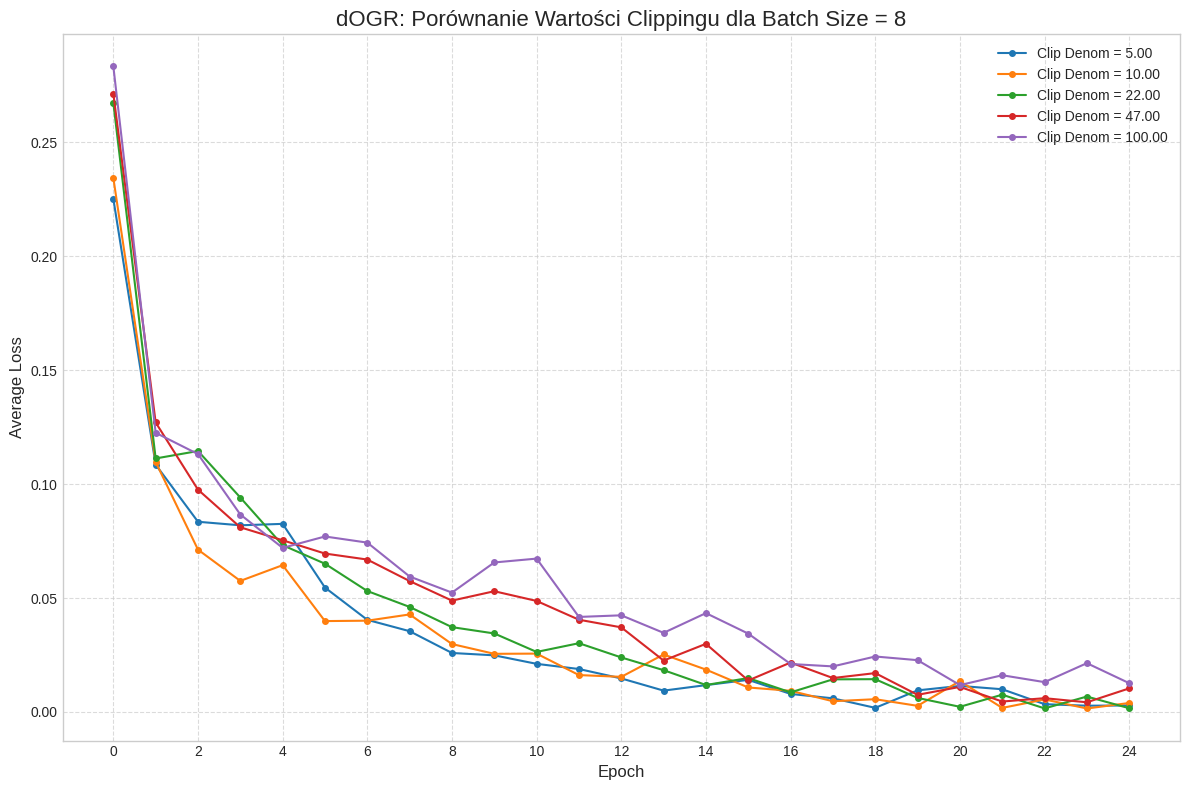

logs/dOGR_Grid_Search/bs_16_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_16_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_16_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_16_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_16_clip_100/metrics.csv
Wykres dla batch_size=16 zapisano w: logs/dOGR_Grid_Search/comparison_bs_16.png


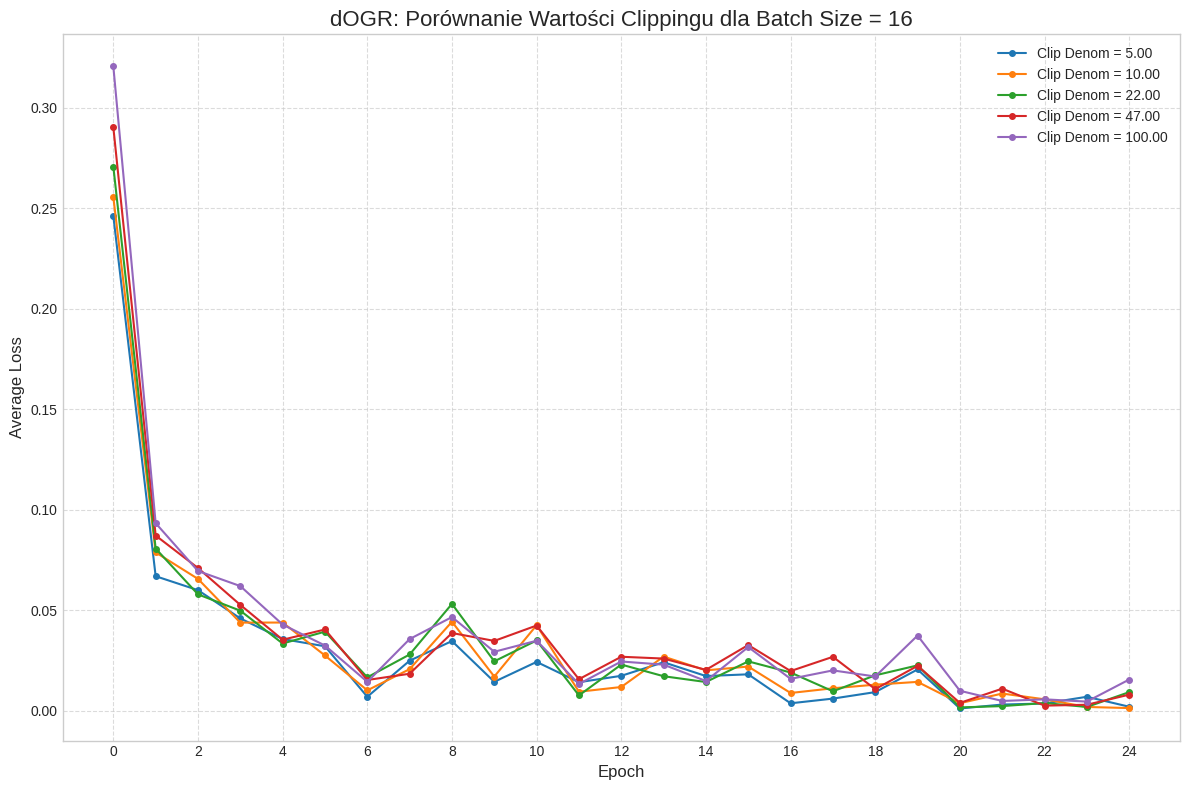

logs/dOGR_Grid_Search/bs_32_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_32_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_32_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_32_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_32_clip_100/metrics.csv
Wykres dla batch_size=32 zapisano w: logs/dOGR_Grid_Search/comparison_bs_32.png


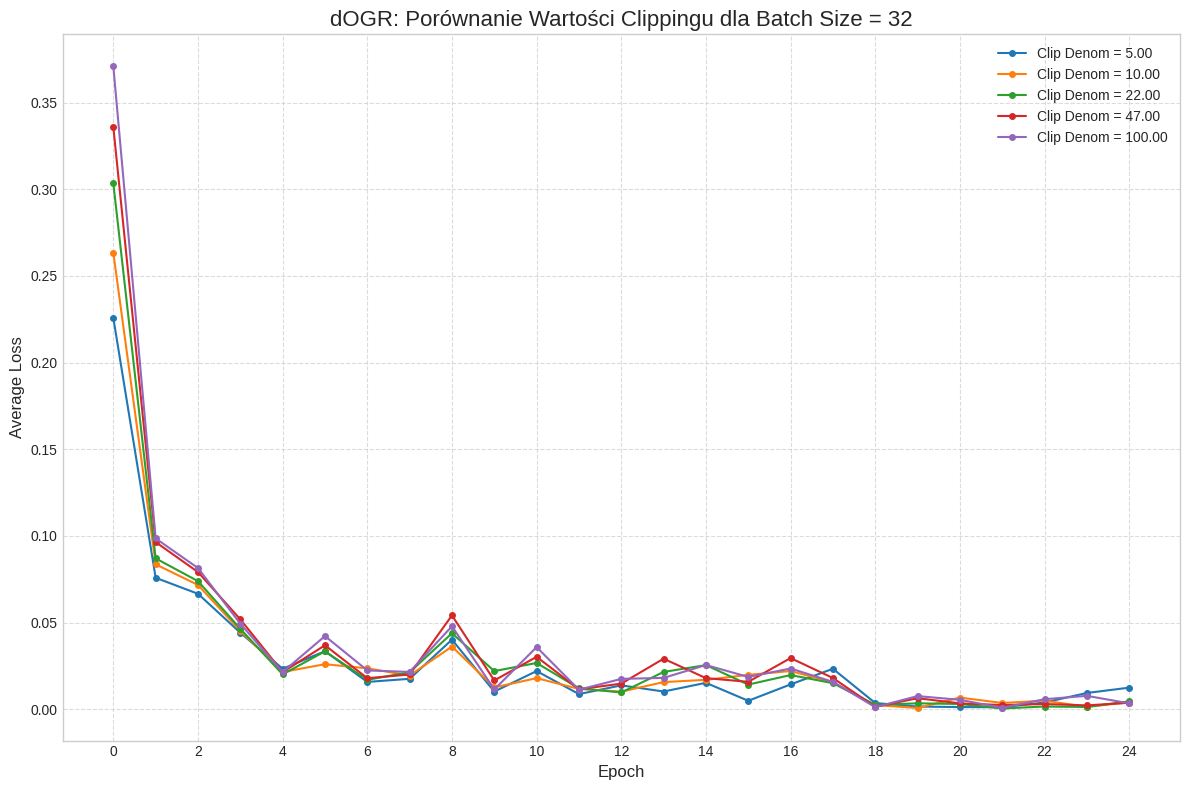

logs/dOGR_Grid_Search/bs_64_clip_5/metrics.csv
logs/dOGR_Grid_Search/bs_64_clip_10/metrics.csv
logs/dOGR_Grid_Search/bs_64_clip_22/metrics.csv
logs/dOGR_Grid_Search/bs_64_clip_47/metrics.csv
logs/dOGR_Grid_Search/bs_64_clip_100/metrics.csv
Wykres dla batch_size=64 zapisano w: logs/dOGR_Grid_Search/comparison_bs_64.png


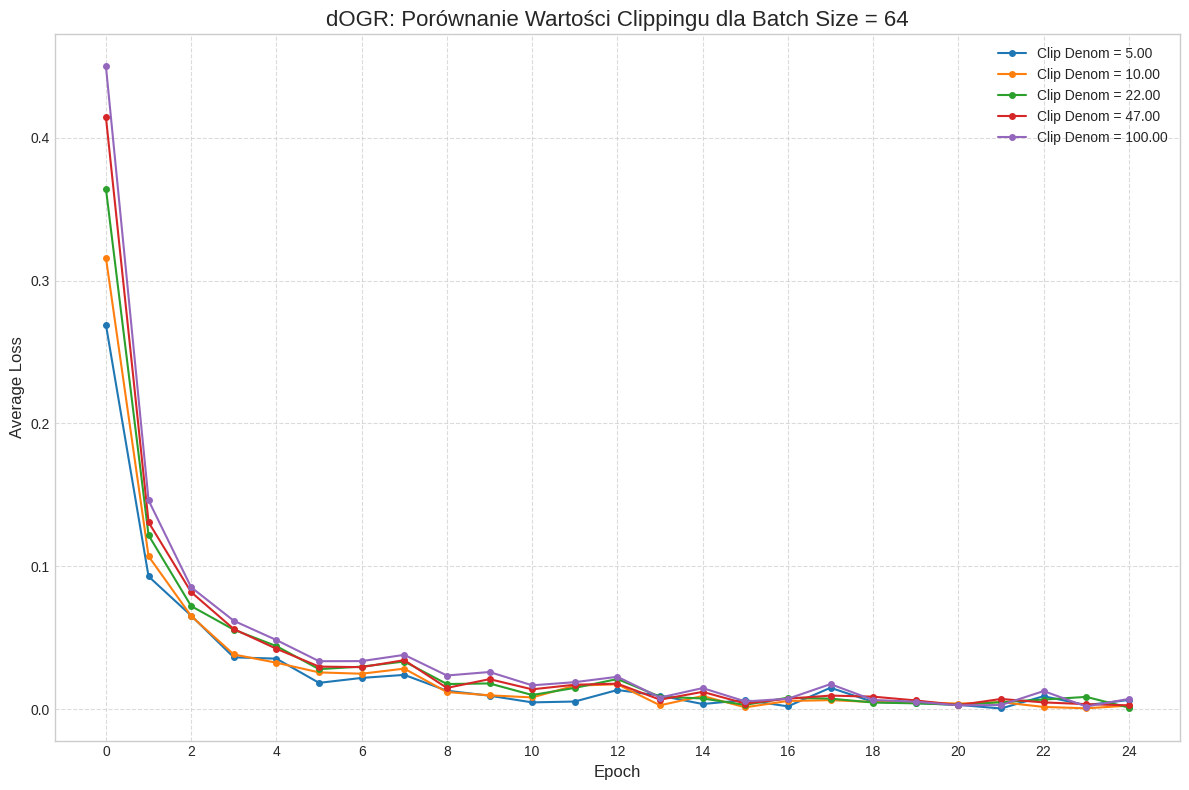

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import itertools
import numpy as np

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Grid_Search"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
NET = "LeNet"
LEARNING_RATE = 1e-3

param_grid = {
    'batch_size': [1, 4, 8, 16, 32, 64],
    'neg_clip_val': np.logspace(np.log10(5), np.log10(100), 5, dtype=int).tolist() 
}
BATCH_SIZES = param_grid['batch_size']
CLIPPING_VALUES = param_grid['neg_clip_val']

def plot_separate_charts_by_batch_size():
    """Generuje osobny wykres porównawczy dla każdego rozmiaru paczki."""
    print("\n--- Generowanie osobnych wykresów dla każdego batch size ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    
    for batch_size in BATCH_SIZES:
        plt.figure(figsize=(12, 8))
        
        found_any_logs_for_bs = False
        for clip_val in CLIPPING_VALUES:
            version_name = f"bs_{batch_size}_clip_{clip_val}"
            path = LOGGING_DIR / EXPERIMENT_NAME / f"{version_name}" / "metrics.csv"
            print(path)
            if not path.exists():
                continue
                
            found_any_logs_for_bs = True
            df = pd.read_csv(path)
            train_loss_df = df[["epoch", "train_loss"]].dropna().groupby("epoch").mean().reset_index()

            plt.plot(train_loss_df["epoch"], train_loss_df["train_loss"], "o-", label=f"Clip Denom = {clip_val:.2f}", markersize=4)

        if not found_any_logs_for_bs:
            print(f"Nie znaleziono żadnych logów dla batch_size={batch_size}, pomijam wykres.")
            plt.close() 
            continue

        plt.title(f"dOGR: Porównanie Wartości Clippingu dla Batch Size = {batch_size}", fontsize=16)
        plt.xlabel("Epoch", fontsize=12)
        plt.ylabel("Average Loss", fontsize=12)
        plt.legend()
        plt.grid(True, which='both', linestyle="--", alpha=0.7)
        plt.xticks(range(0, MAX_EPOCHS, 2))
        plt.tight_layout()
        
        plot_path = LOGGING_DIR / EXPERIMENT_NAME / f"comparison_bs_{batch_size}.png"
        plt.savefig(plot_path)
        print(f"Wykres dla batch_size={batch_size} zapisano w: {plot_path}")
        plt.show() 


if __name__ == "__main__":
    plot_separate_charts_by_batch_size()

In [1]:
import os

os.chdir("..")

## Testy nonlinear clippingu z dOGR

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import itertools
import numpy as np

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Grid_Search_nonlinear_clipping"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
NET = "LeNet"
LEARNING_RATE = 1e-3

# Siatka parametrow do przeszukania
param_grid = {
    'batch_size': [32, 64],
    'p_norm': [0.25, 0.5, 1.0, 1.5, 2.0, 4.0, 8.0, 16.0],
    'p_eps': [0.1, 0.5, 1.0, 2.0, 5.0]
}

experiments = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
BATCH_SIZES = param_grid['batch_size']
P_NORM = param_grid['p_norm']

experiments = []
keys, values = zip(*param_grid.items())
for v in itertools.product(*values):
    experiments.append(dict(zip(keys, v)))

def run_all_experiments():
    """Uruchamia serię eksperymentów dla każdej kombinacji parametrów."""
    total_experiments = len(experiments)
    print(f"--- Uruchamianie {total_experiments} eksperymentów (Grid Search) ---")
    
    for i, config in enumerate(experiments):
        batch_size = config['batch_size']
        p_norm = config['p_norm']
        p_eps = config['p_eps']

        p_norm_str = f"p_norm_{p_norm}" if p_norm is not None else "no_p_norm"
        p_eps_str = f"p_eps_{p_eps}" if p_eps is not None else "no_p_eps"
        version_name = f"bs_{batch_size}_{p_norm_str}_{p_eps_str}"

        print(f"\n[{i+1}/{total_experiments}] Uruchamianie: {version_name}")
        
        torch.manual_seed(42)
        net = net_dict[NET]()
        
        optimizer = dOGR(
            net.parameters(), 
            lr=LEARNING_RATE, 
            nonlinear_clipping=True, 
            p_norm=p_norm,
            p_eps=p_eps
        )
        
        try:
            run(
                net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
                version=version_name, max_epochs=MAX_EPOCHS, batch_size=batch_size
            )
        except Exception as e:
            print(f"Błąd podczas eksperymentu z config = {config}: {e}")
            print("Pominięto ten przebieg.")

    print("\n--- Wszystkie eksperymenty zakończone ---")

if __name__ == "__main__":
    run_all_experiments()

In module products __package__, __name__ == tests tests.main


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In module products __package__, __name__ == tests tests.trainloop
--- Uruchamianie 80 eksperymentów (Grid Search) ---

[1/80] Uruchamianie: bs_32_p_norm_0.25_p_eps_0.1



  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 66.81it/s, v_num=_0.1]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 66.77it/s, v_num=_0.1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 179.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.1335555762052536
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[2/80] Uruchamianie: bs_32_p_norm_0.25_p_eps_0.5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 58.41it/s, v_num=_0.5]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 58.38it/s, v_num=_0.5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 177.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.87000274658203
        test_loss           0.1069386750459671
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[3/80] Uruchamianie: bs_32_p_norm_0.25_p_eps_1.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:28<00:00, 61.23it/s, v_num=_1.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:28<00:00, 61.20it/s, v_num=_1.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 176.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.9000015258789
        test_loss           0.08385223150253296
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[4/80] Uruchamianie: bs_32_p_norm_0.25_p_eps_2.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:27<00:00, 63.34it/s, v_num=_2.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:27<00:00, 63.30it/s, v_num=_2.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:02<00:00, 126.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.9000015258789
        test_loss           0.0789458155632019
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[5/80] Uruchamianie: bs_32_p_norm_0.25_p_eps_5.0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 58.25it/s, v_num=_5.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 58.20it/s, v_num=_5.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 172.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.76000213623047
        test_loss           0.08650235086679459
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[6/80] Uruchamianie: bs_32_p_norm_0.5_p_eps_0.1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:26<00:00, 65.97it/s, v_num=_0.1]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:26<00:00, 65.93it/s, v_num=_0.1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 168.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          96.61000061035156
        test_loss           0.2842804789543152
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[7/80] Uruchamianie: bs_32_p_norm_0.5_p_eps_0.5


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:27<00:00, 63.40it/s, v_num=_0.5]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:27<00:00, 63.36it/s, v_num=_0.5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 171.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.79000091552734
        test_loss           0.16222597658634186
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[8/80] Uruchamianie: bs_32_p_norm_0.5_p_eps_1.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 57.87it/s, v_num=_1.0]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:29<00:00, 57.84it/s, v_num=_1.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:02<00:00, 154.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.87999725341797
        test_loss           0.13068197667598724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[9/80] Uruchamianie: bs_32_p_norm_0.5_p_eps_2.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:26<00:00, 64.84it/s, v_num=_2.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:26<00:00, 64.80it/s, v_num=_2.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 168.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.93000030517578
        test_loss           0.08869364112615585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[10/80] Uruchamianie: bs_32_p_norm_0.5_p_eps_5.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:24<00:00, 68.96it/s, v_num=_5.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:24<00:00, 68.92it/s, v_num=_5.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 187.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          99.02999877929688
        test_loss           0.07983473688364029
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[11/80] Uruchamianie: bs_32_p_norm_1.0_p_eps_0.1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.17it/s, v_num=_0.1]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.13it/s, v_num=_0.1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 183.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                47.25
        test_loss           1.3895602226257324
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[12/80] Uruchamianie: bs_32_p_norm_1.0_p_eps_0.5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.25it/s, v_num=_0.5]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.21it/s, v_num=_0.5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 187.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.05999755859375
        test_loss           0.2979007661342621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[13/80] Uruchamianie: bs_32_p_norm_1.0_p_eps_1.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.19it/s, v_num=_1.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.15it/s, v_num=_1.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 175.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.98999786376953
        test_loss           0.16536946594715118
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[14/80] Uruchamianie: bs_32_p_norm_1.0_p_eps_2.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.14it/s, v_num=_2.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.10it/s, v_num=_2.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 174.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          99.19999694824219
        test_loss           0.08851232379674911
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[15/80] Uruchamianie: bs_32_p_norm_1.0_p_eps_5.0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.69it/s, v_num=_5.0]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 67.65it/s, v_num=_5.0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 174.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.95999908447266
        test_loss           0.08320207893848419
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[16/80] Uruchamianie: bs_32_p_norm_1.5_p_eps_0.1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.27it/s, v_num=_0.1]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.22it/s, v_num=_0.1]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 175.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         30.450000762939453
        test_loss            1.761262059211731
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[17/80] Uruchamianie: bs_32_p_norm_1.5_p_eps_0.5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.16it/s, v_num=_0.5]   

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 1719/1719 [00:25<00:00, 68.11it/s, v_num=_0.5]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 313/313 [00:01<00:00, 170.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.44000244140625
        test_loss           0.3425016403198242
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[18/80] Uruchamianie: bs_32_p_norm_1.5_p_eps_1.0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Validation DataLoader 0:  82%|████████▏ | 129/157 [00:00<00:00, 138.81it/s]

In [2]:
import os

os.chdir("..")


--- Generowanie wykresów pogrupowanych po p_norm ---
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.25_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.25_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.25_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.25_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.25_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.25_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.25_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.25_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.25_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.25_p_eps_5.0/metrics.csv
Wykres dla p_norm=0.25 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_0.25.png


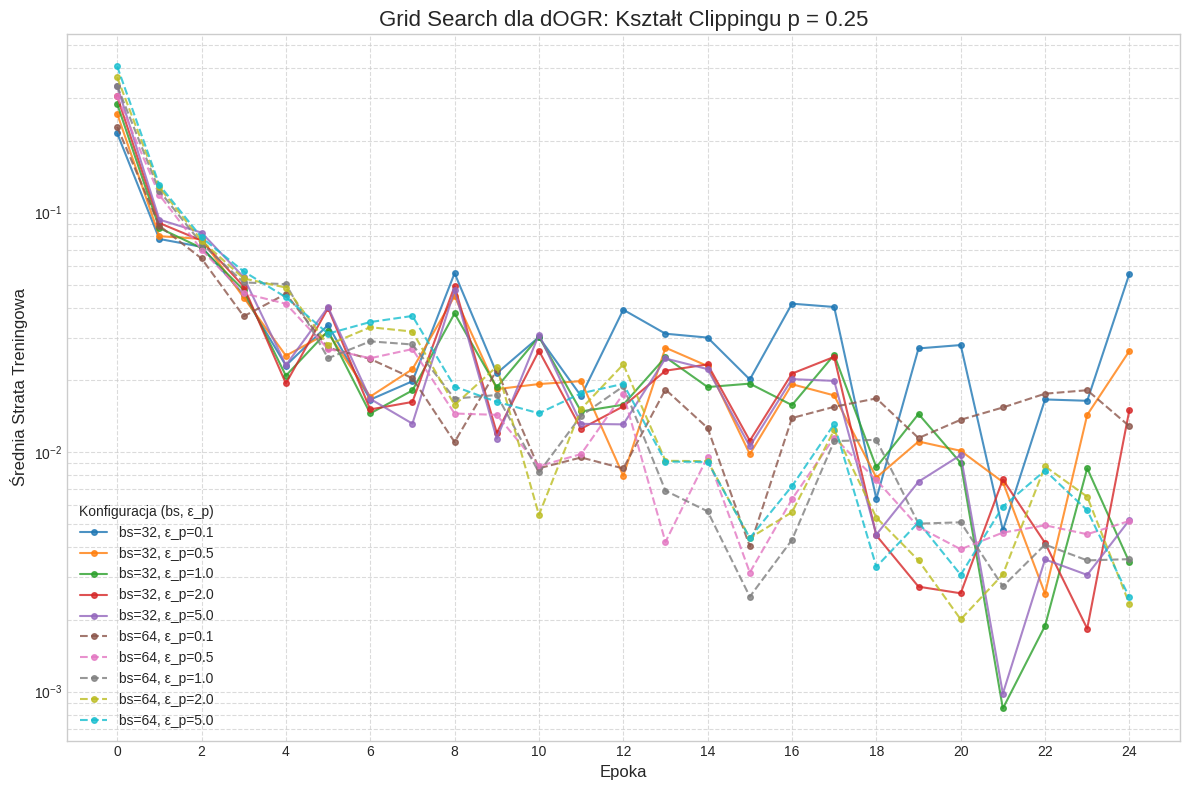

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.5_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.5_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.5_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.5_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_0.5_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.5_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.5_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.5_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.5_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_0.5_p_eps_5.0/metrics.csv
Wykres dla p_norm=0.5 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_0.50.png


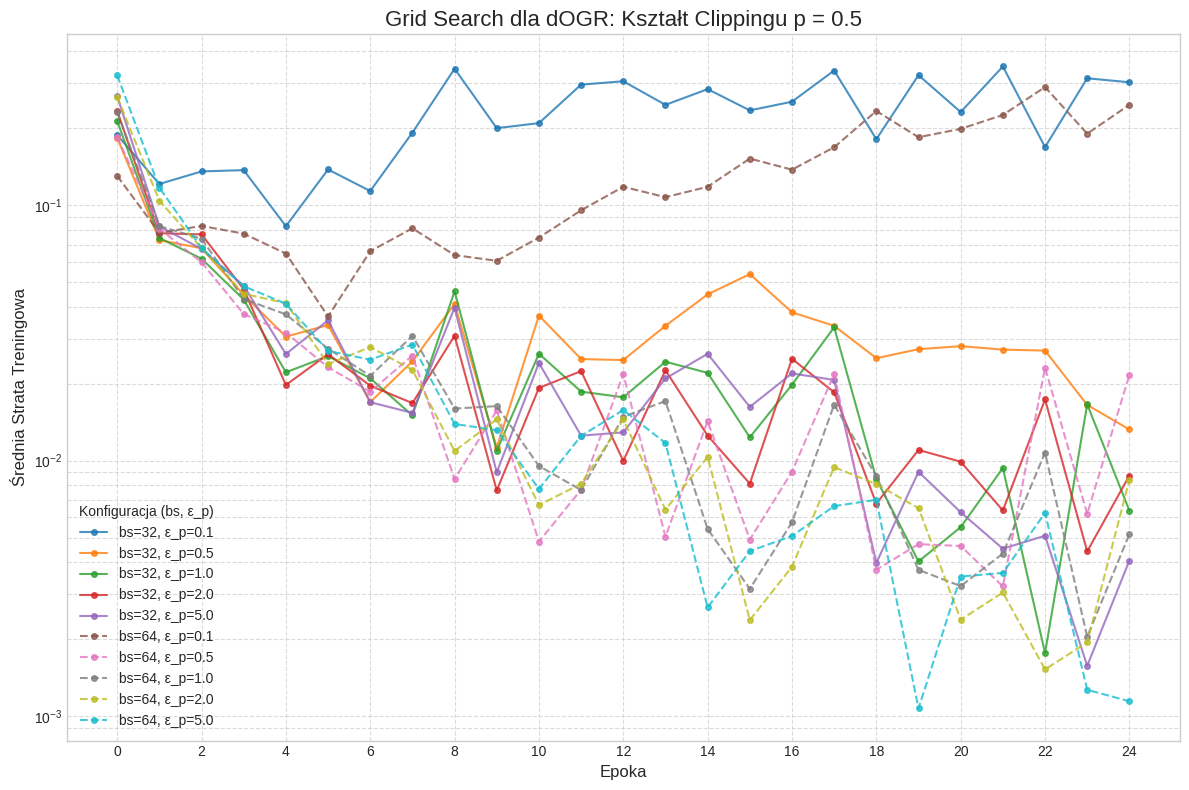

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.0_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.0_p_eps_5.0/metrics.csv
Wykres dla p_norm=1.0 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_1.00.png


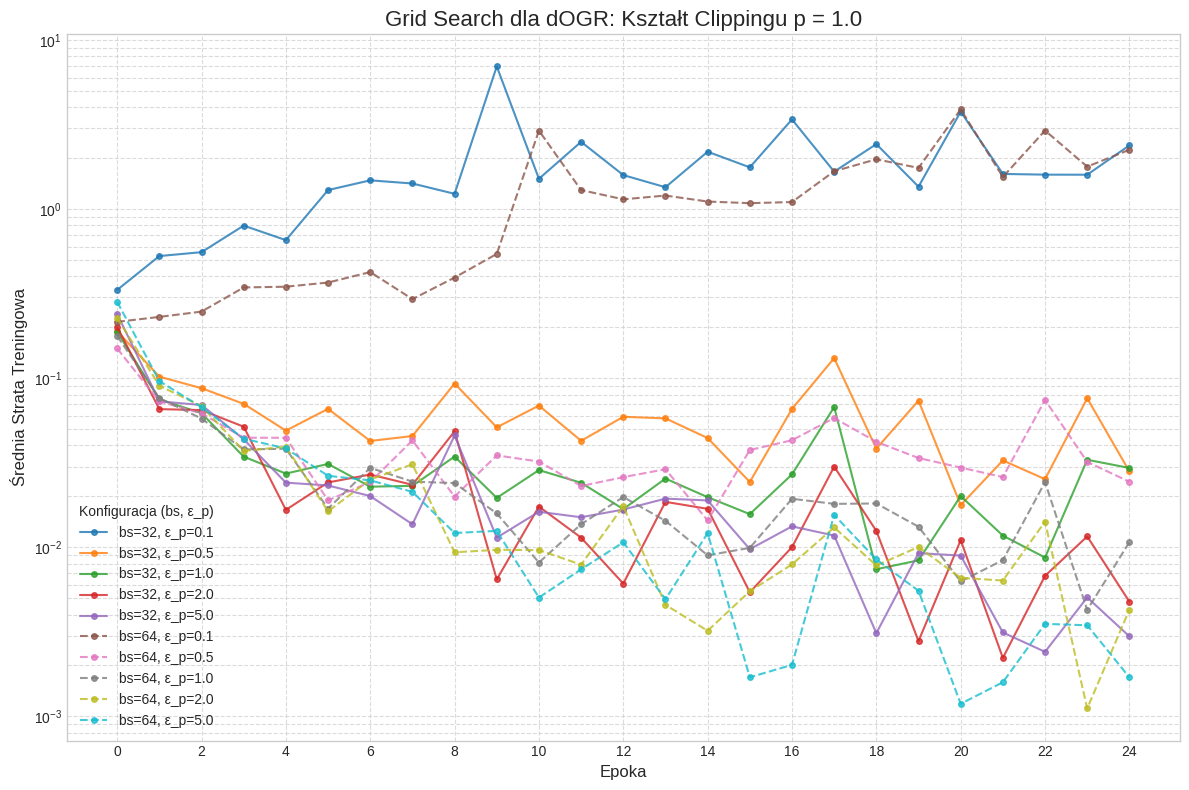

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.5_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.5_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.5_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.5_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_1.5_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.5_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.5_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.5_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.5_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_1.5_p_eps_5.0/metrics.csv
Wykres dla p_norm=1.5 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_1.50.png


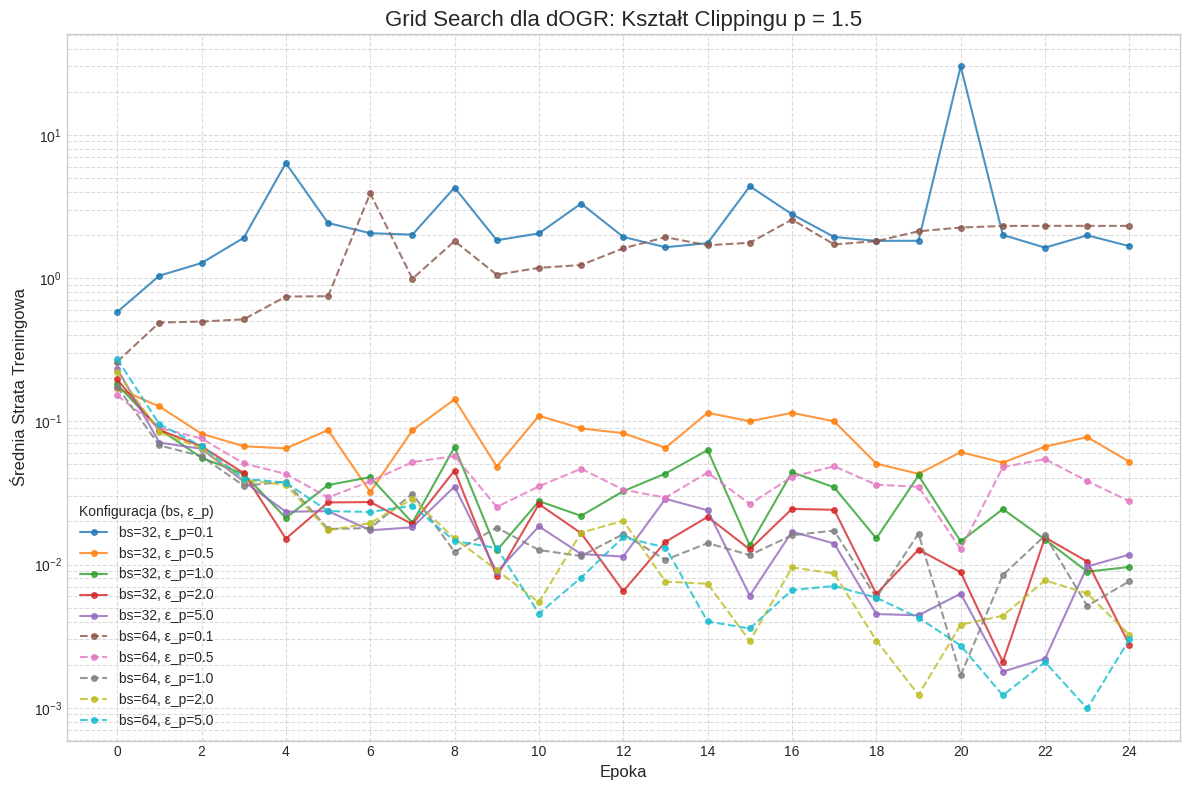

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_2.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_2.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_2.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_2.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_2.0_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_2.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_2.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_2.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_2.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_2.0_p_eps_5.0/metrics.csv
Wykres dla p_norm=2.0 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_2.00.png


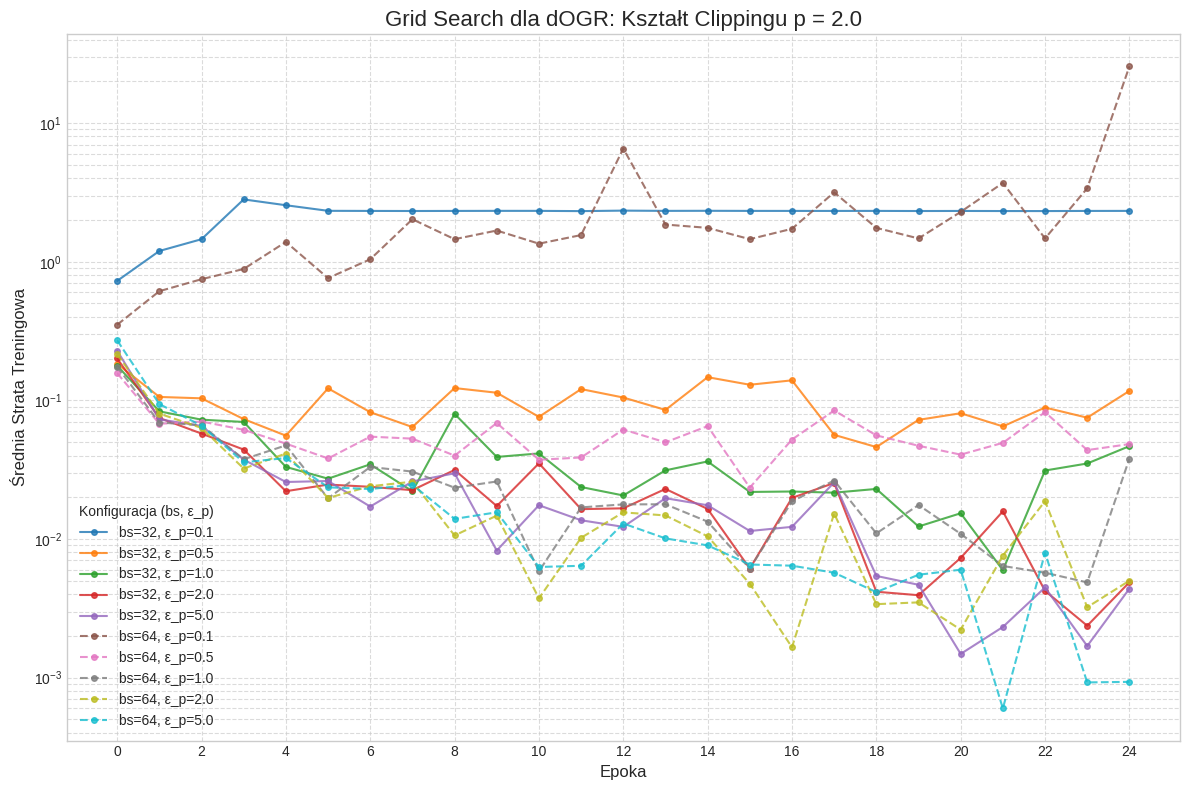

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_4.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_4.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_4.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_4.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_4.0_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_4.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_4.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_4.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_4.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_4.0_p_eps_5.0/metrics.csv
Wykres dla p_norm=4.0 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_4.00.png


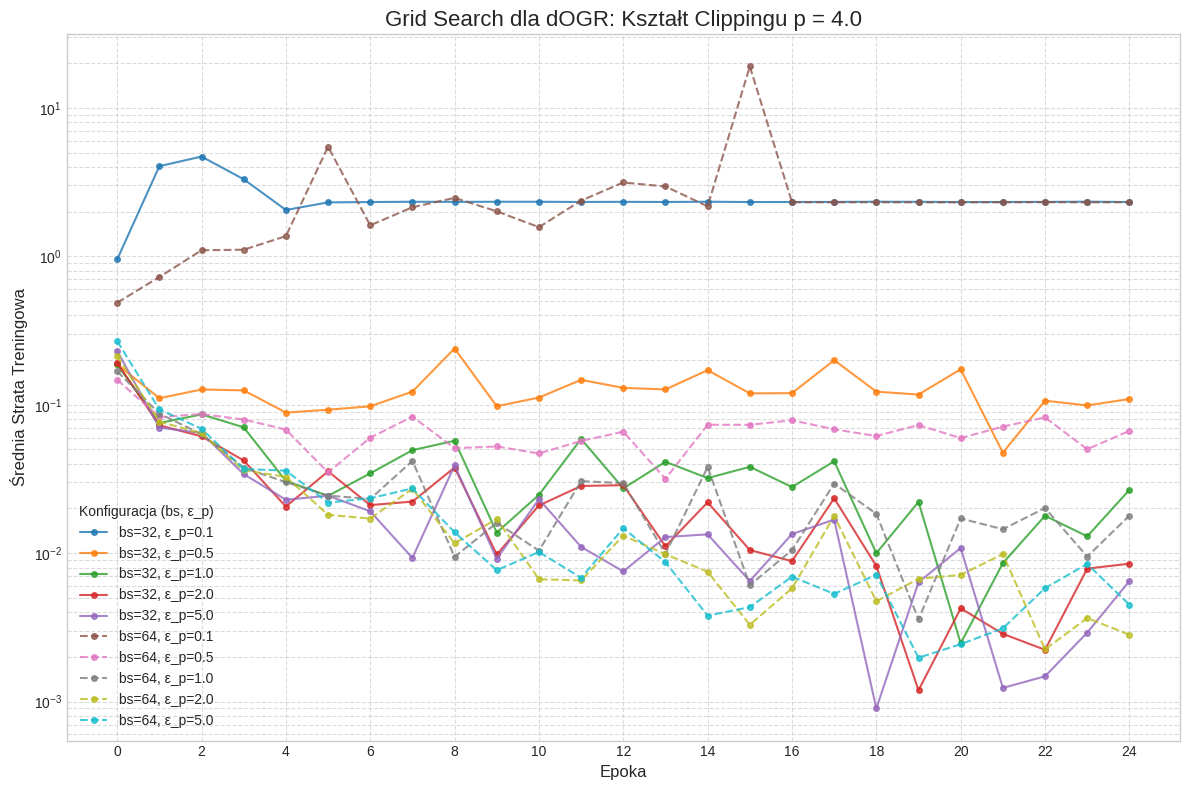

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_8.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_8.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_8.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_8.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_8.0_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_8.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_8.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_8.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_8.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_8.0_p_eps_5.0/metrics.csv
Wykres dla p_norm=8.0 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_8.00.png


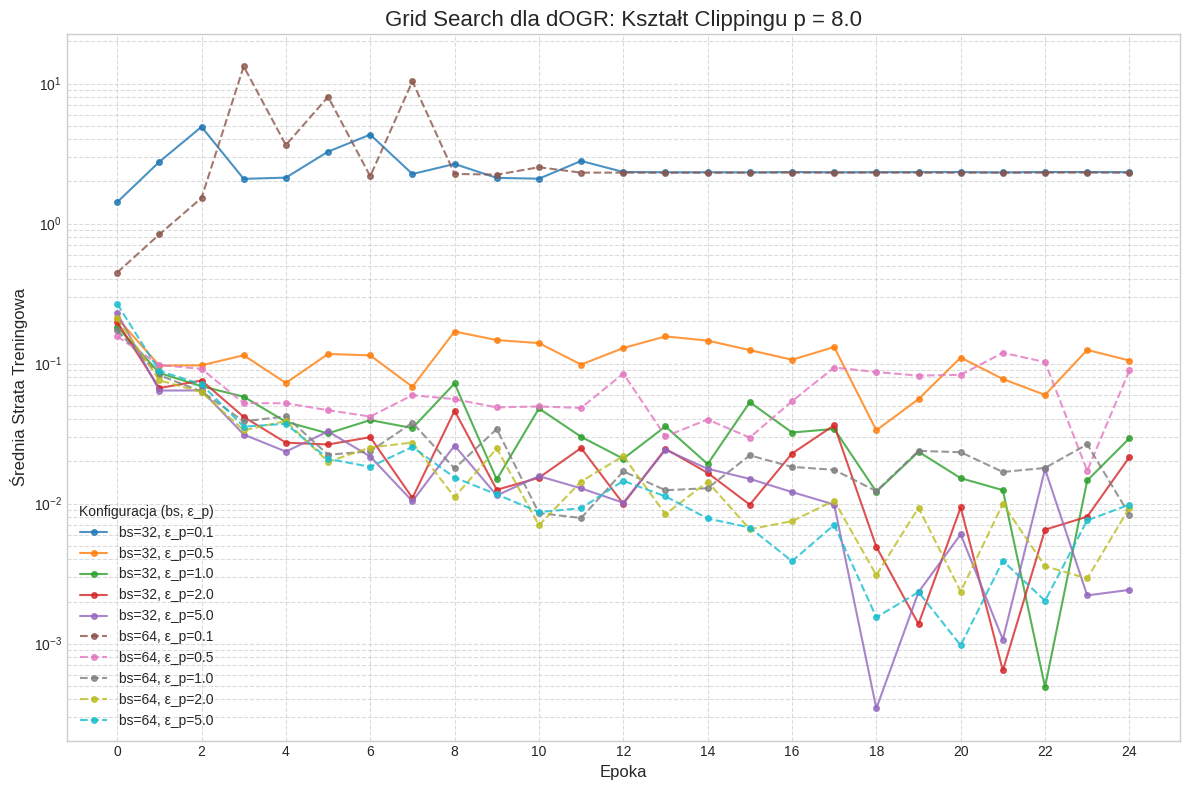

logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_16.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_16.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_16.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_16.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_32_p_norm_16.0_p_eps_5.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_16.0_p_eps_0.1/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_16.0_p_eps_0.5/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_16.0_p_eps_1.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_16.0_p_eps_2.0/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping/bs_64_p_norm_16.0_p_eps_5.0/metrics.csv
Wykres dla p_norm=16.0 zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping/plot_images/grouped_by_p_norm_16.00.png


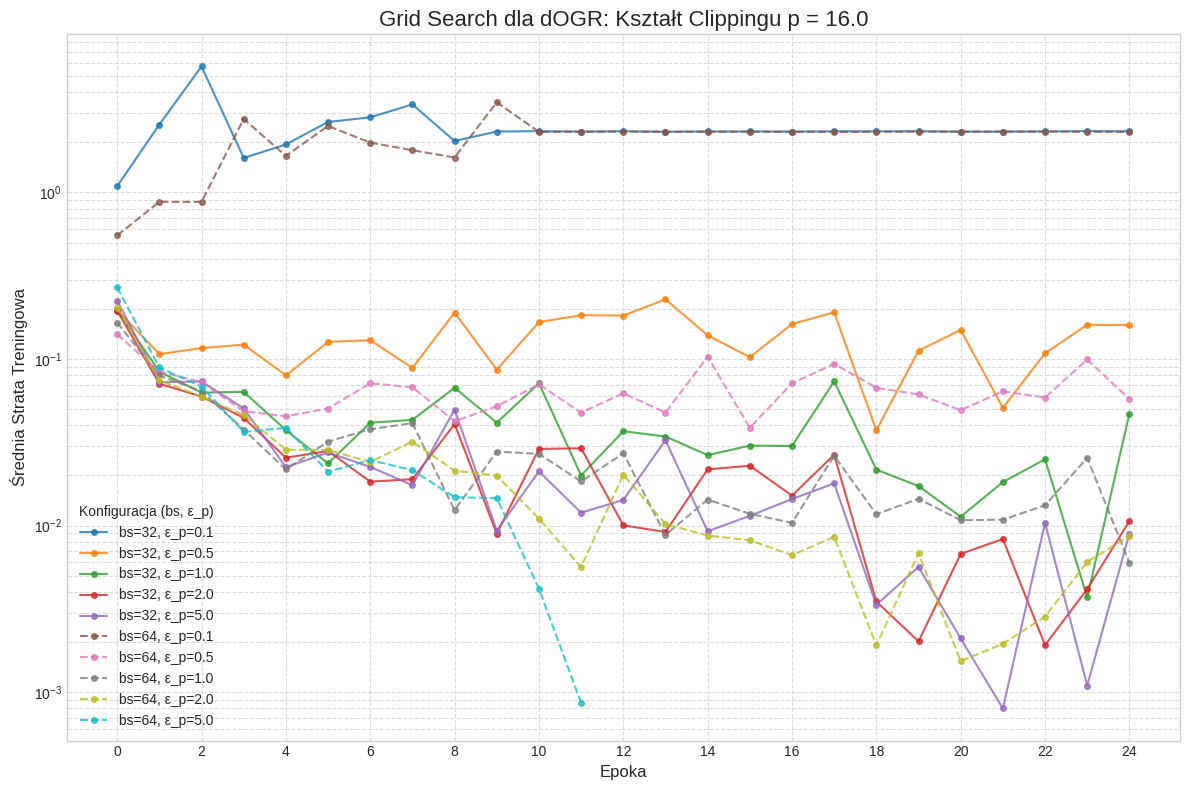

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import itertools
import numpy as np

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Grid_Search_nonlinear_clipping"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
NET = "LeNet"
LEARNING_RATE = 1e-3

# Siatka parametrow do przeszukania
param_grid = {
    'batch_size': [32, 64],
    'p_norm': [0.25, 0.5, 1.0, 1.5, 2.0, 4.0, 8.0, 16.0],
    'p_eps': [0.1, 0.5, 1.0, 2.0, 5.0]
}
BATCH_SIZES = param_grid['batch_size']
P_VALUES = param_grid['p_norm']
EPS_VALUES = param_grid['p_eps']

def plot_grouped_by_p_norm():
    print("\n--- Generowanie wykresów pogrupowanych po p_norm ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    
    for p_val in P_VALUES:
        plt.figure(figsize=(12, 8))
        
        for batch_size in BATCH_SIZES:
            for eps_p_val in EPS_VALUES:
                version_name = f"bs_{batch_size}_p_norm_{p_val}_p_eps_{eps_p_val}"
                path = LOGGING_DIR / EXPERIMENT_NAME / f"{version_name}" / "metrics.csv"
                print(path)
                
                if not path.exists():
                    continue
                
                found_any_logs_for_p_val = True
                df = pd.read_csv(path)
                train_loss_df = df[["epoch", "train_loss"]].dropna().groupby("epoch").mean().reset_index()
                
                line_style = "-" if batch_size == 32 else "--"
                plt.plot(train_loss_df["epoch"], train_loss_df["train_loss"], linestyle=line_style,
                         label=f"bs={batch_size}, ε_p={eps_p_val}", marker='o', markersize=4, alpha=0.8)
                
                if not found_any_logs_for_p_val:
                    print(f"Nie znaleziono żadnych logów dla p_norm={p_val}, pomijam wykres.")
                    plt.close() 
                    continue

        plt.title(f"Grid Search dla dOGR: Kształt Clippingu p = {p_val}", fontsize=16)
        plt.xlabel("Epoka", fontsize=12)
        plt.ylabel("Średnia Strata Treningowa", fontsize=12)
        plt.legend(title="Konfiguracja (bs, ε_p)")
        plt.grid(True, which='both', linestyle="--", alpha=0.7)
        plt.xticks(range(0, MAX_EPOCHS + 1, 2))
        # plt.ylim(0, 0.4)
        plt.yscale('log')  
        plt.tight_layout()

        plot_path = LOGGING_DIR / EXPERIMENT_NAME / "plot_images" / f"grouped_by_p_norm_{p_val:.2f}.png"
        plt.savefig(plot_path)
        print(f"Wykres dla p_norm={p_val} zapisano w: {plot_path}")
        plt.show()

if __name__ == "__main__":
    plot_grouped_by_p_norm()

## Testy nonlinear clipping dOGR, tuning parametrow p_norm, p_eps, beta, trust_factor

In [1]:
import os

os.chdir("..")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import itertools
import numpy as np

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
NET = "LeNet"
LEARNING_RATE = 1e-3

# Siatka parametrow do przeszukania
param_grid = {
    'batch_size': [64],
    # 4 punkty liniowo rozłożone w najbardziej obiecującym zakresie od 0.1 do 0.5
    'p_norm': np.linspace(0.1, 1.5, 4).tolist(),
    # 4 punkty logarytmicznie rozłożone w stabilnym zakresie od 1.0 do 10.0
    'p_eps': np.logspace(np.log10(5.0), np.log10(50.0), 4).tolist(),
    'beta': np.linspace(0.1, 0.9, 4).tolist(),
    'trust_factor': np.linspace(0.1, 1.0, 4).tolist()
}

experiments = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
BATCH_SIZES = param_grid['batch_size']
P_VALUES = param_grid['p_norm']
EPS_VALUES = param_grid['p_eps']
BETA = param_grid['beta']
TRUST_FACTOR = param_grid['trust_factor']

experiments = []
keys, values = zip(*param_grid.items())
for v in itertools.product(*values):
    experiments.append(dict(zip(keys, v)))

def run_all_experiments():
    """Uruchamia serię eksperymentów dla każdej kombinacji parametrów."""
    total_experiments = len(experiments)
    print(f"--- Uruchamianie {total_experiments} eksperymentów (Grid Search) ---")
    
    for i, config in enumerate(experiments):
        batch_size = config['batch_size']
        p_norm = config['p_norm']
        p_eps = config['p_eps']
        beta = config['beta']
        trust_factor = config['trust_factor']

        p_norm_str = f"p_norm_{p_norm:.2f}" if p_norm is not None else "no_p_norm"
        p_eps_str = f"p_eps_{p_eps:.2f}" if p_eps is not None else "no_p_eps"
        beta_str = f"beta_{beta:.2f}" if beta is not None else "no_beta"
        trust_factor_str = f"trust_factor_{trust_factor:.2f}" if trust_factor is not None else "no_trust_factor"
        version_name = f"bs_{batch_size}_{p_norm_str}_{p_eps_str}_{beta_str}_{trust_factor_str}"

        print(f"\n[{i+1}/{total_experiments}] Uruchamianie: {version_name}")
        
        torch.manual_seed(42)
        net = net_dict[NET]()
        
        optimizer = dOGR(
            net.parameters(), 
            lr=LEARNING_RATE, 
            nonlinear_clipping=True, 
            p_norm=p_norm,
            p_eps=p_eps,
            beta=beta,
            trust_factor=trust_factor
        )
        
        try:
            run(
                net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
                version=version_name, max_epochs=MAX_EPOCHS, batch_size=batch_size
            )
        except Exception as e:
            print(f"Błąd podczas eksperymentu z config = {config}: {e}")
            print("Pominięto ten przebieg.")

    print("\n--- Wszystkie eksperymenty zakończone ---")

if __name__ == "__main__":
    run_all_experiments()

In module products __package__, __name__ == tests tests.main


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In module products __package__, __name__ == tests tests.trainloop
--- Uruchamianie 256 eksperymentów (Grid Search) ---

[1/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.10_trust_factor_0.10



  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.97it/s, v_num=0.10]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.90it/s, v_num=0.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 159.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.44999694824219
        test_loss           0.08269157260656357
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[2/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.10_trust_factor_0.40


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.93it/s, v_num=0.40]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.85it/s, v_num=0.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 160.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.73999786376953
        test_loss          0.045687563717365265
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[3/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.10_trust_factor_0.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.73it/s, v_num=0.70]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.65it/s, v_num=0.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 159.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          99.02999877929688
        test_loss           0.04783688113093376
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[4/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.10_trust_factor_1.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.82it/s, v_num=1.00]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.75it/s, v_num=1.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 148.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.98999786376953
        test_loss           0.05422341823577881
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[5/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.37_trust_factor_0.10


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.45it/s, v_num=0.10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.38it/s, v_num=0.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 163.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.69999694824219
        test_loss           0.07862069457769394
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[6/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.37_trust_factor_0.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.35it/s, v_num=0.40]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.27it/s, v_num=0.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 146.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.77999877929688
        test_loss           0.04263375699520111
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[7/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.37_trust_factor_0.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.21it/s, v_num=0.70]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.14it/s, v_num=0.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 143.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.9800033569336
        test_loss          0.039470963180065155
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[8/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.37_trust_factor_1.00


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.98it/s, v_num=1.00]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.90it/s, v_num=1.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 156.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.69999694824219
        test_loss           0.05668344721198082
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[9/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.63_trust_factor_0.10


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.31it/s, v_num=0.10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.23it/s, v_num=0.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 156.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.80999755859375
        test_loss           0.07396246492862701
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[10/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.63_trust_factor_0.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 62.91it/s, v_num=0.40]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 62.83it/s, v_num=0.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 148.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.66000366210938
        test_loss           0.04946022853255272
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[11/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.63_trust_factor_0.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.14it/s, v_num=0.70]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.07it/s, v_num=0.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 153.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.62999725341797
        test_loss          0.054797932505607605
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[12/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.63_trust_factor_1.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 60.99it/s, v_num=1.00]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 60.93it/s, v_num=1.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 143.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.58999633789062
        test_loss           0.06748493760824203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[13/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.90_trust_factor_0.10


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.47it/s, v_num=0.10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.40it/s, v_num=0.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 157.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.63999938964844
        test_loss           0.07674098759889603
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[14/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.90_trust_factor_0.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.29it/s, v_num=0.40]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.21it/s, v_num=0.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 152.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.52999877929688
        test_loss           0.05710766464471817
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[15/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.90_trust_factor_0.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.49it/s, v_num=0.70]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.42it/s, v_num=0.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 139.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.66000366210938
        test_loss           0.05072850361466408
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[16/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_5.00_beta_0.90_trust_factor_1.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.42it/s, v_num=1.00]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.32it/s, v_num=1.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 142.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.97000122070312
        test_loss           0.0859602838754654
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[17/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.10_trust_factor_0.10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.42it/s, v_num=0.10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.34it/s, v_num=0.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 153.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.4000015258789
        test_loss           0.08346649259328842
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[18/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.10_trust_factor_0.40


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:20<00:00, 42.54it/s, v_num=0.40]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:20<00:00, 42.49it/s, v_num=0.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 114.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.87000274658203
        test_loss           0.04572901874780655
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[19/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.10_trust_factor_0.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:16<00:00, 52.97it/s, v_num=0.70]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:16<00:00, 52.89it/s, v_num=0.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 124.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          99.01000213623047
        test_loss           0.04569297656416893
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[20/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.10_trust_factor_1.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 57.54it/s, v_num=1.00]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 57.47it/s, v_num=1.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 159.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.97000122070312
        test_loss          0.048814501613378525
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[21/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.37_trust_factor_0.10


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 58.12it/s, v_num=0.10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 58.05it/s, v_num=0.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 133.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.62999725341797
        test_loss           0.07913602143526077
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[22/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.37_trust_factor_0.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 65.95it/s, v_num=0.40]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 65.86it/s, v_num=0.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 155.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.7300033569336
        test_loss           0.04537196829915047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[23/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.37_trust_factor_0.70


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 66.27it/s, v_num=0.70]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 66.19it/s, v_num=0.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 147.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.80999755859375
        test_loss          0.041527289897203445
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[24/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.37_trust_factor_1.00


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.27it/s, v_num=1.00]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 63.19it/s, v_num=1.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 153.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.9000015258789
        test_loss           0.05068916082382202
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[25/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.63_trust_factor_0.10


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 66.74it/s, v_num=0.10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 66.67it/s, v_num=0.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 157.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.7300033569336
        test_loss           0.0755714550614357
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[26/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.63_trust_factor_0.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.89it/s, v_num=0.40]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 64.81it/s, v_num=0.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 162.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.69999694824219
        test_loss           0.04629584401845932
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[27/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.63_trust_factor_0.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 67.40it/s, v_num=0.70]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 67.31it/s, v_num=0.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 170.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.69999694824219
        test_loss           0.05274490267038345
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[28/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.63_trust_factor_1.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:17<00:00, 50.32it/s, v_num=1.00]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:17<00:00, 50.27it/s, v_num=1.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 143.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.05252223461866379
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[29/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.90_trust_factor_0.10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 61.93it/s, v_num=0.10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:13<00:00, 61.87it/s, v_num=0.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 133.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.58999633789062
        test_loss           0.0788654237985611
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[30/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.90_trust_factor_0.40


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:15<00:00, 56.97it/s, v_num=0.40]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:15<00:00, 56.91it/s, v_num=0.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 145.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.5999984741211
        test_loss           0.05355904996395111
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[31/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.90_trust_factor_0.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:17<00:00, 49.21it/s, v_num=0.70]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:17<00:00, 49.16it/s, v_num=0.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 85.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.08999633789062
        test_loss           0.06794529408216476
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[32/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_10.77_beta_0.90_trust_factor_1.00

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 58.36it/s, v_num=1.00]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 58.28it/s, v_num=1.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 144.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.4000015258789
        test_loss           0.05350382253527641
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[33/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_23.21_beta_0.10_trust_factor_0.10


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 60.71it/s, v_num=0.10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 60.65it/s, v_num=0.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 140.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.37999725341797
        test_loss           0.08472920954227448
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[34/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_23.21_beta_0.10_trust_factor_0.40


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:17<00:00, 50.34it/s, v_num=0.40]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:17<00:00, 50.29it/s, v_num=0.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 90.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.87999725341797
        test_loss           0.0424342006444931
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[35/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_23.21_beta_0.10_trust_factor_0.70


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 66.23it/s, v_num=0.70]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 66.16it/s, v_num=0.70]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 170.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.95999908447266
        test_loss           0.04580749571323395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[36/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_23.21_beta_0.10_trust_factor_1.00


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 66.37it/s, v_num=1.00]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 66.29it/s, v_num=1.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 170.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          99.05999755859375
        test_loss           0.05105168744921684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[37/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_23.21_beta_0.37_trust_factor_0.10


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 66.39it/s, v_num=0.10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:12<00:00, 66.28it/s, v_num=0.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 175.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.6500015258789
        test_loss           0.07940579950809479
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[38/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_23.21_beta_0.37_trust_factor_0.40


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 57.83it/s, v_num=0.40]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 860/860 [00:14<00:00, 57.76it/s, v_num=0.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 134.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.87000274658203
        test_loss          0.042813174426555634
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[39/256] Uruchamianie: bs_64_p_norm_0.10_p_eps_23.21_beta_0.37_trust_factor_0.70


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 13:  16%|█▋        | 140/860 [00:02<00:10, 66.15it/s, v_num=0.70]    

In [1]:
import os

os.chdir("..")

--- Generowanie wykresów analitycznych ---
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.10_p_eps_10.77_beta_0.10_trust_factor_1.00/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.10_trust_factor_1.00/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_1.03_p_eps_10.77_beta_0.10_trust_factor_1.00/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_1.50_p_eps_10.77_beta_0.10_trust_factor_1.00/metrics.csv
Wykres dla 'p_norm' zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/analysis_plots/effect_of_p_norm.png


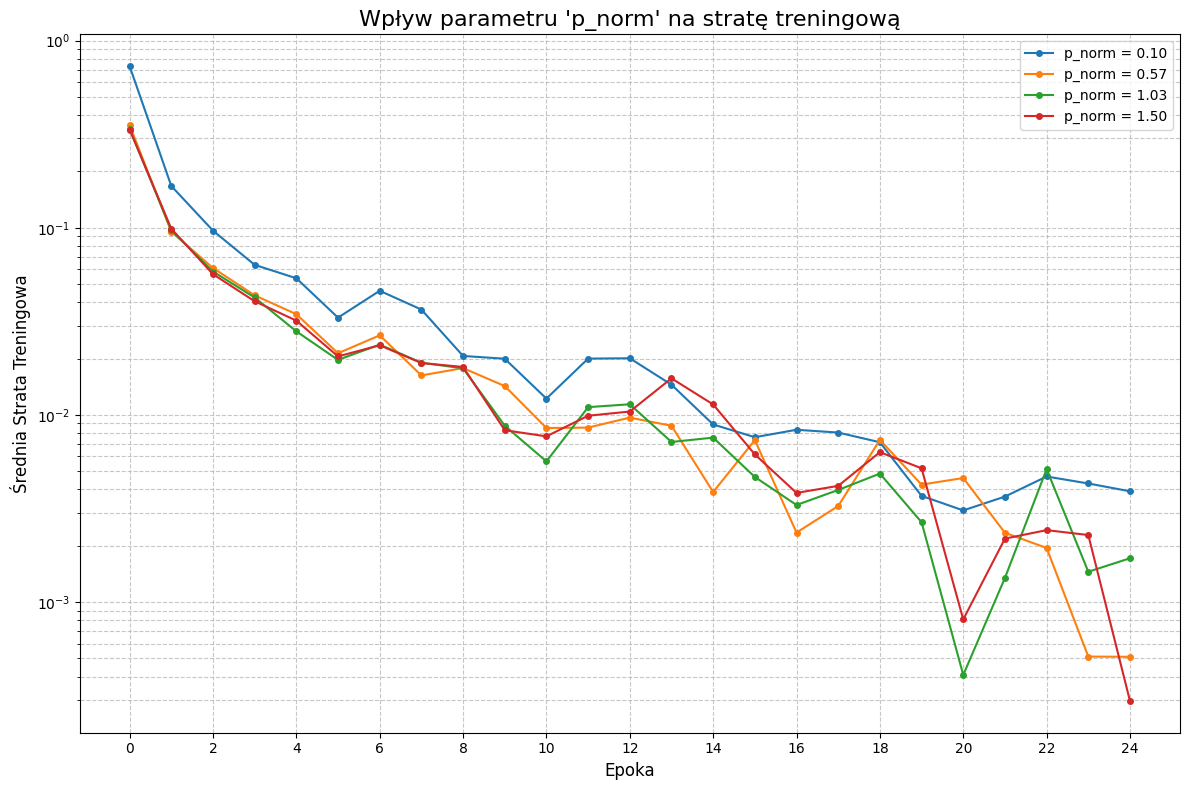

logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_5.00_beta_0.10_trust_factor_1.00/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.10_trust_factor_1.00/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_23.21_beta_0.10_trust_factor_1.00/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_50.00_beta_0.10_trust_factor_1.00/metrics.csv
Wykres dla 'p_eps' zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/analysis_plots/effect_of_p_eps.png


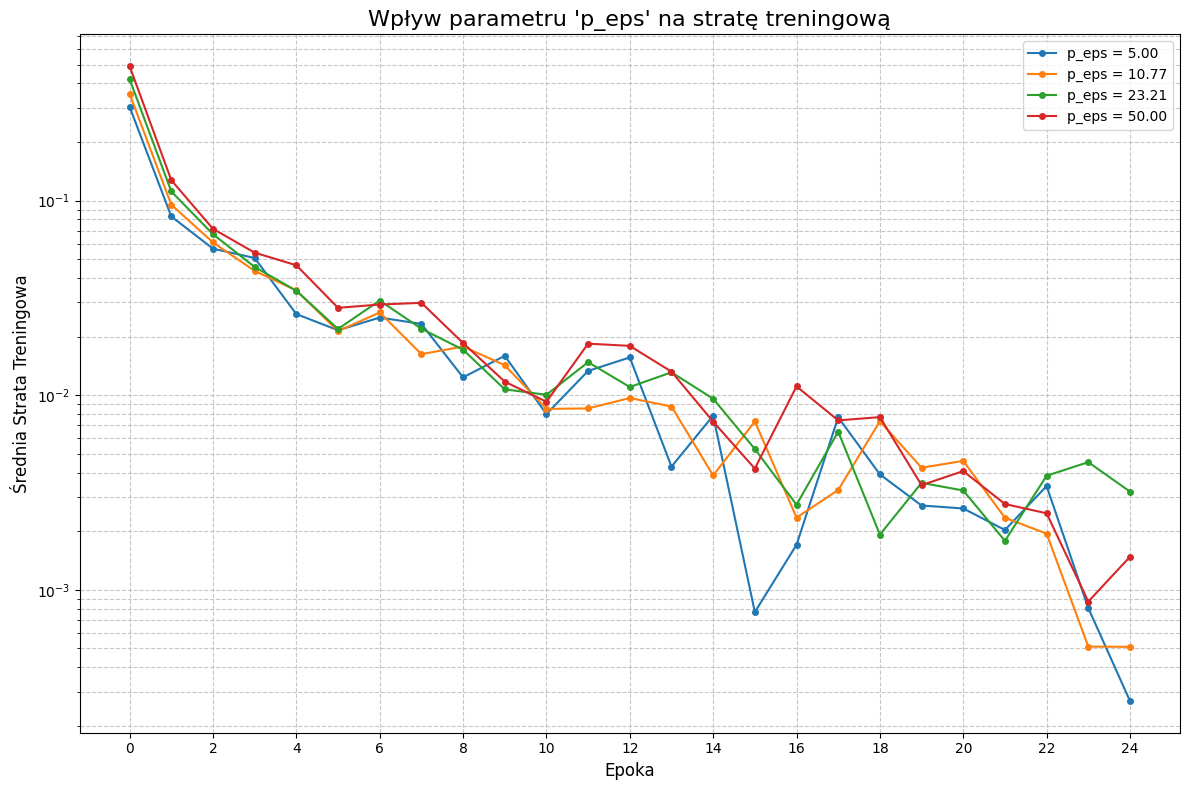

logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.10_trust_factor_1.00/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.37_trust_factor_1.00/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.63_trust_factor_1.00/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.90_trust_factor_1.00/metrics.csv
Wykres dla 'beta' zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/analysis_plots/effect_of_beta.png


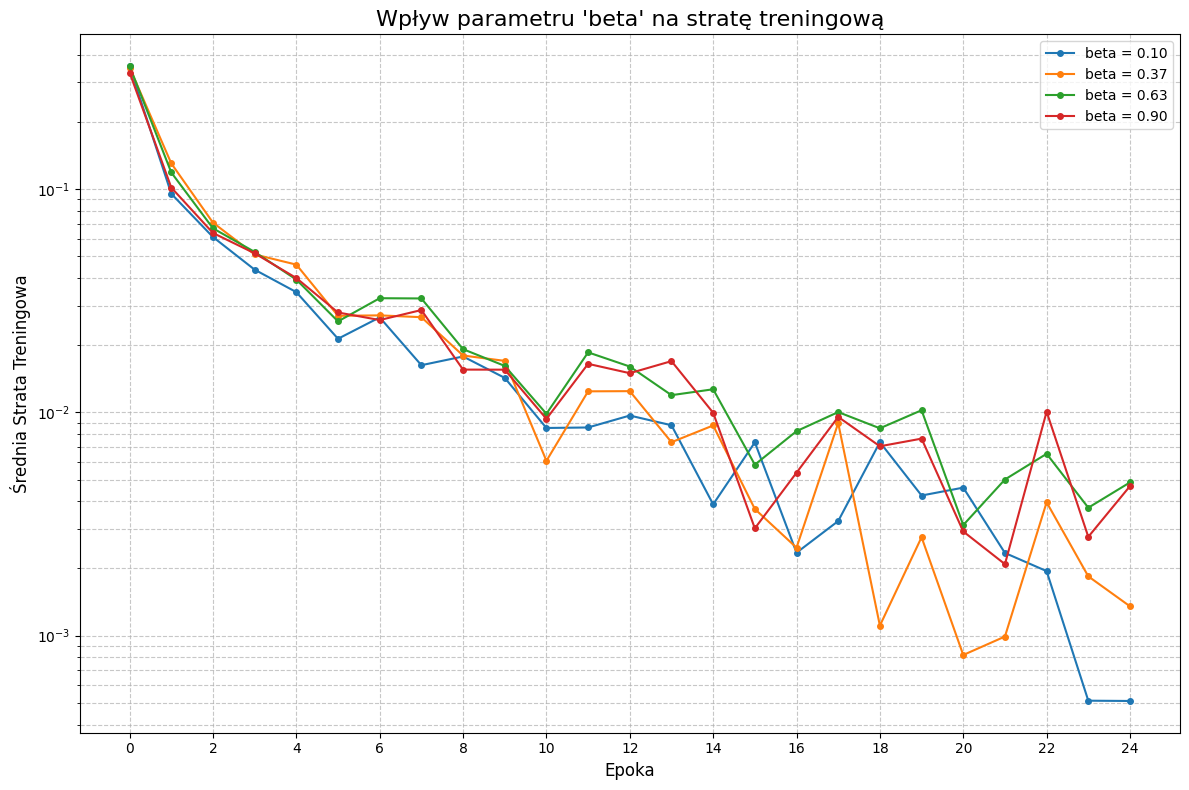

logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.10_trust_factor_0.10/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.10_trust_factor_0.40/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.10_trust_factor_0.70/metrics.csv
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.10_trust_factor_1.00/metrics.csv
Wykres dla 'trust_factor' zapisano w: logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/analysis_plots/effect_of_trust_factor.png


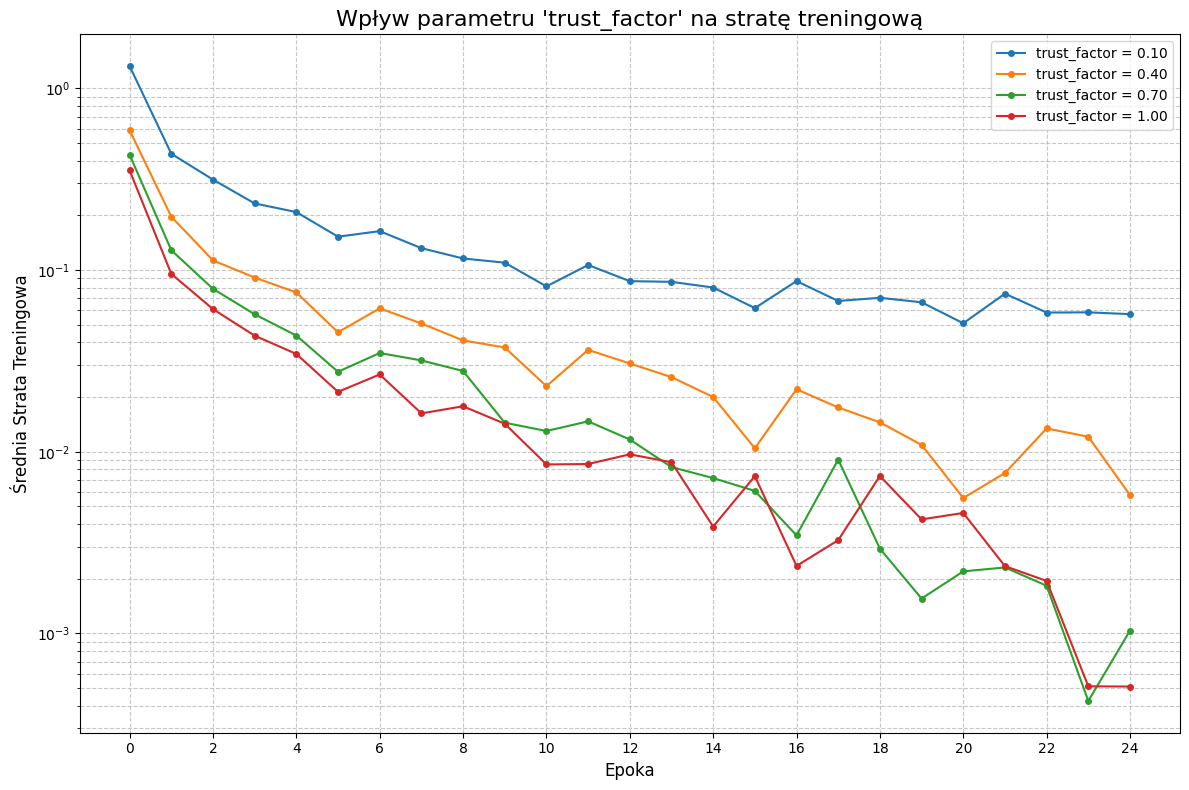

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

EXPERIMENT_NAME = "dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25

param_grid = {
    'batch_size': [64],
    'p_norm': np.linspace(0.1, 1.5, 4).tolist(),
    'p_eps': np.logspace(np.log10(5.0), np.log10(50.0), 4).tolist(),
    'beta': np.linspace(0.1, 0.9, 4).tolist(),
    'trust_factor': np.linspace(0.1, 1.0, 4).tolist()
}
P_VALUES = param_grid['p_norm']
EPS_VALUES = param_grid['p_eps']
BETA_VALUES = param_grid['beta']
TRUST_FACTOR_VALUES = param_grid['trust_factor']

# --- Zdefiniuj "najlepszą" lub domyślną konfigurację ---
# Po pierwszej analizie możesz tu wstawić najlepsze znalezione wartości
BEST_PARAMS = {
    'batch_size': 64,
    'p_norm': 0.57,
    'p_eps': 10.77,
    'beta': 0.1,
    'trust_factor': 1.0
}

def plot_single_param_effect(param_to_vary, values_to_test, fixed_params):
    """
    Funkcja pomocnicza do rysowania wpływu jednego parametru.
    """
    plt.figure(figsize=(12, 8))
    
    for value in values_to_test:
        current_params = fixed_params.copy()
        current_params[param_to_vary] = value
        
        bs = current_params['batch_size']
        p_norm = current_params['p_norm']
        p_eps = current_params['p_eps']
        beta = current_params['beta']
        trust_factor = current_params['trust_factor']
        
        version_name = f"bs_{bs}_p_norm_{p_norm:.2f}_p_eps_{p_eps:.2f}_beta_{beta:.2f}_trust_factor_{trust_factor:.2f}"
        path = LOGGING_DIR / EXPERIMENT_NAME / version_name / "metrics.csv"
        print(path)
        
        if not path.exists():
            continue
            
        df = pd.read_csv(path)
        loss_df = df[["epoch", "train_loss"]].dropna().groupby("epoch").mean().reset_index()
        plt.plot(loss_df["epoch"], loss_df["train_loss"], "o-", label=f"{param_to_vary} = {value:.2f}", markersize=4)

    plt.title(f"Wpływ parametru '{param_to_vary}' na stratę treningową", fontsize=16)
    plt.xlabel("Epoka", fontsize=12)
    plt.ylabel("Średnia Strata Treningowa", fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle="--", alpha=0.7)
    plt.xticks(range(0, MAX_EPOCHS + 1, 2))
    plt.yscale('log') 
    plt.tight_layout()
    
    output_dir = LOGGING_DIR / EXPERIMENT_NAME / "analysis_plots"
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_path = output_dir / f"effect_of_{param_to_vary}.png"
    plt.savefig(plot_path)
    print(f"Wykres dla '{param_to_vary}' zapisano w: {plot_path}")
    plt.show()

if __name__ == "__main__":
    print("--- Generowanie wykresów analitycznych ---")
    
    # Wykres 1: Wpływ p_norm (reszta stała)
    plot_single_param_effect('p_norm', P_VALUES, BEST_PARAMS)
    
    # Wykres 2: Wpływ p_eps (reszta stała)
    plot_single_param_effect('p_eps', EPS_VALUES, BEST_PARAMS)

    # Wykres 3: Wpływ beta (reszta stała)
    plot_single_param_effect('beta', BETA_VALUES, BEST_PARAMS)

    # Wykres 4: Wpływ trust_factor (reszta stała)
    plot_single_param_effect('trust_factor', TRUST_FACTOR_VALUES, BEST_PARAMS)

In [ ]:
import pandas as pd
from pathlib import Path
import itertools
import numpy as np

# --- Konfiguracja (musi być identyczna jak w skrypcie treningowym) ---
EXPERIMENT_NAME = "dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow"
LOGGING_DIR = Path("logs")

# Siatka parametrów, która była testowana
param_grid = {
    'batch_size': [64],
    'p_norm': np.linspace(0.1, 1.5, 4).tolist(),
    'p_eps': np.logspace(np.log10(5.0), np.log10(50.0), 4).tolist(),
    'beta': np.linspace(0.1, 0.9, 4).tolist(),
    'trust_factor': np.linspace(0.1, 1.0, 4).tolist()
}


experiments = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]


def find_best_combination():
    """
    Przeszukuje wszystkie logi, znajduje końcową stratę i sortuje wyniki.
    """
    print(f"\n--- Analizowanie wyników z folderu: {LOGGING_DIR / EXPERIMENT_NAME} ---")
    
    all_results = []

    for config in experiments:

        bs = config['batch_size']
        p_norm = config['p_norm']
        p_eps = config['p_eps']
        beta = config['beta']
        trust_factor = config['trust_factor']

        version_name = f"bs_{bs}_p_norm_{p_norm:.2f}_p_eps_{p_eps:.2f}_beta_{beta:.2f}_trust_factor_{trust_factor:.2f}"
        path = LOGGING_DIR / EXPERIMENT_NAME / version_name / "metrics.csv"

        if not path.exists():
            continue

        try:
            df = pd.read_csv(path)

            final_loss_row = df[["epoch", "train_loss"]].dropna().iloc[-1]
            
            result = {
                "config": config,
                "loss": final_loss_row['train_loss'],
                "epoch": int(final_loss_row['epoch'])
            }
            all_results.append(result)
        except (pd.errors.EmptyDataError, IndexError):
            print(f"Ostrzeżenie: Pusty lub niekompletny plik metrics.csv dla {version_name}, pomijam.")
            continue
    
    if not all_results:
        print("Nie znaleziono żadnych poprawnych plików z logami. Sprawdź nazwy folderów i EXPERIMENT_NAME.")
        return


    sorted_results = sorted(all_results, key=lambda x: x['loss'])

    print("\n--- 5 NAJLEPSZYCH KOMBINACJI HIPERPARAMETRÓW ---")
    for i, result in enumerate(sorted_results[:5]):
        print(f"\n{i+1}. Miejsce:")
        print(f"  Końcowa strata: {result['loss']:.18f} (w epoce {result['epoch']})")
        print(f"  Konfiguracja:")
        for key, value in result['config'].items():
            print(f"    - {key}: {value:.4f}")

if __name__ == "__main__":
    find_best_combination()


--- Analizowanie wyników z folderu: logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow ---

--- 5 NAJLEPSZYCH KOMBINACJI HIPERPARAMETRÓW ---

1. Miejsce:
  Końcowa strata: 0.000000009934105982 (w epoce 24)
  Konfiguracja:
    - batch_size: 64.0000
    - p_norm: 0.5667
    - p_eps: 10.7722
    - beta: 0.1000
    - trust_factor: 1.0000

2. Miejsce:
  Końcowa strata: 0.000000009934105982 (w epoce 24)
  Konfiguracja:
    - batch_size: 64.0000
    - p_norm: 1.0333
    - p_eps: 5.0000
    - beta: 0.9000
    - trust_factor: 1.0000

3. Miejsce:
  Końcowa strata: 0.000000019868210188 (w epoce 24)
  Konfiguracja:
    - batch_size: 64.0000
    - p_norm: 1.5000
    - p_eps: 5.0000
    - beta: 0.9000
    - trust_factor: 0.7000

4. Miejsce:
  Końcowa strata: 0.000000019868211965 (w epoce 24)
  Konfiguracja:
    - batch_size: 64.0000
    - p_norm: 1.0333
    - p_eps: 5.0000
    - beta: 0.9000
    - trust_factor: 0.7000

5. Miejsce:
  Końcowa strata: 0.000000044703458713 (w epoce 24)
  Konfig

--- Wyniki Testowe ---

Config 1 (p=1.03):
  Test Loss: 0.0574
  Test Accuracy: 99.02%

Config 2 (p=1.50):
  Test Loss: 0.0570
  Test Accuracy: 99.12%


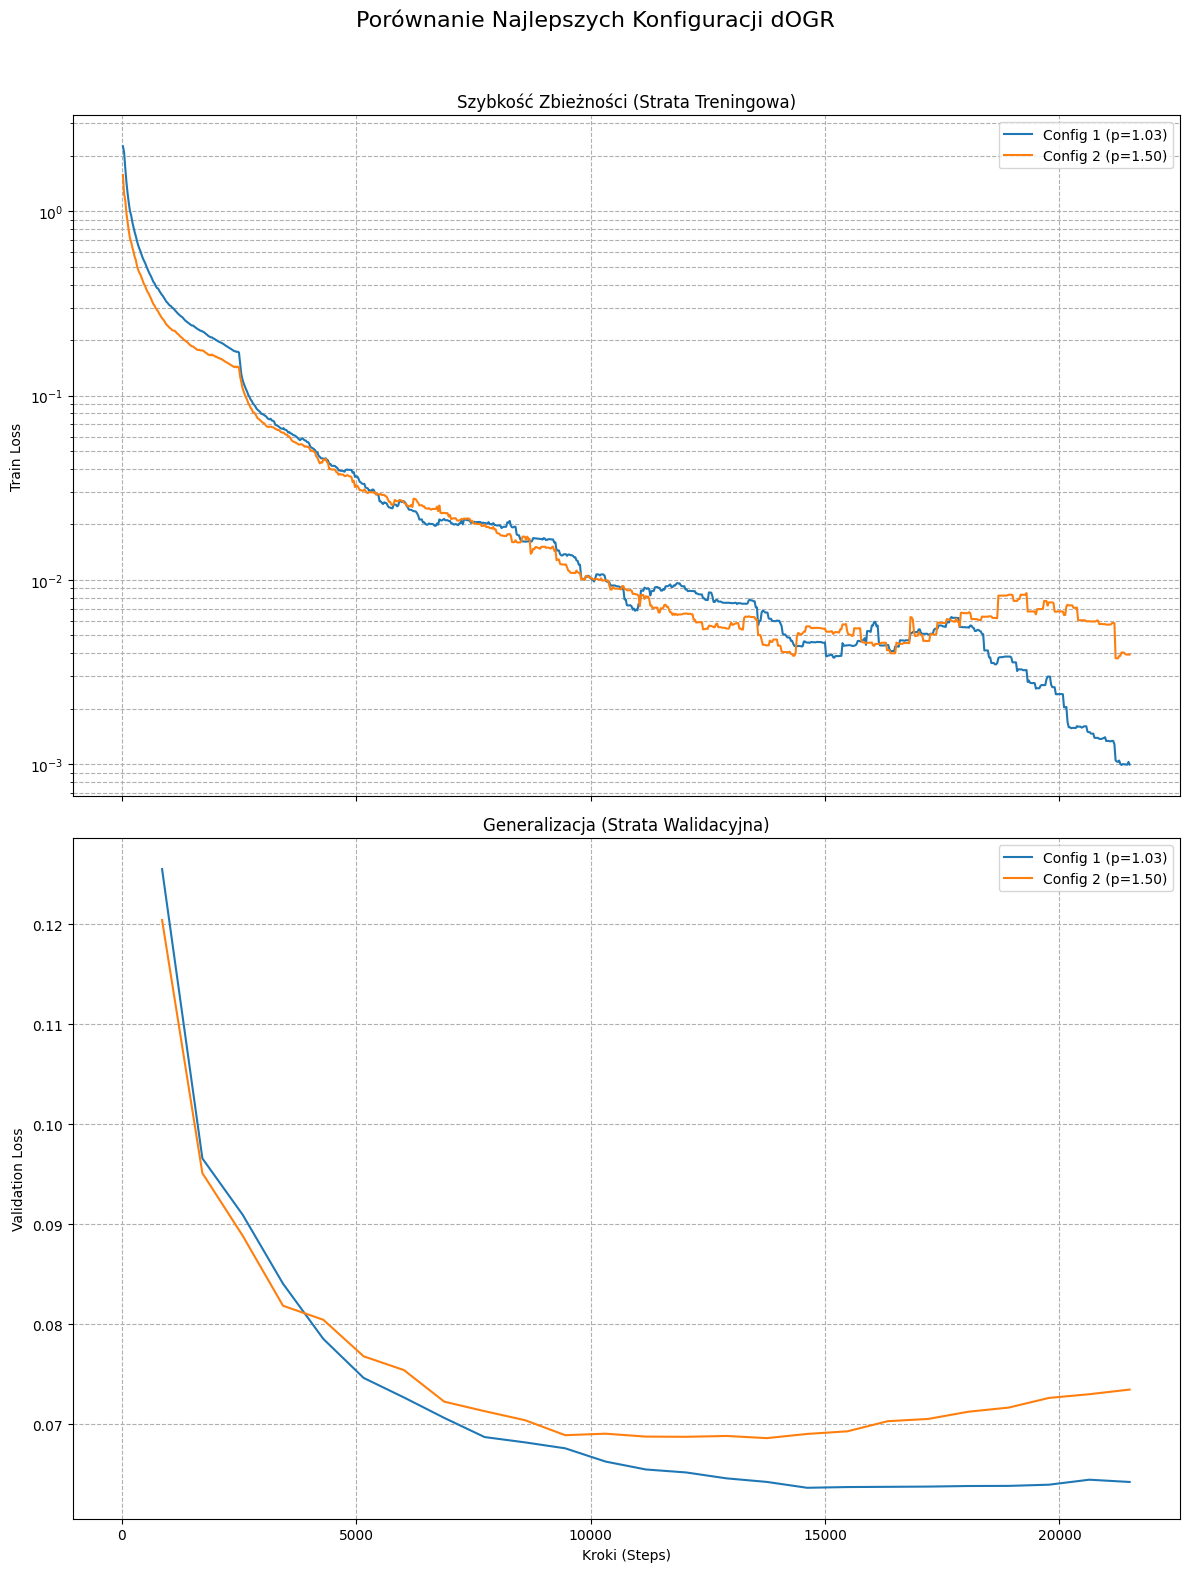

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --- Konfiguracja ---
EXPERIMENT_NAME = "dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow"
LOGGING_DIR = Path("logs")

configs_to_compare = {
    "Config 1 (p=1.03)": "bs_64_p_norm_0.57_p_eps_10.77_beta_0.10_trust_factor_1.00",
    "Config 2 (p=1.50)": "bs_64_p_norm_1.03_p_eps_5.00_beta_0.90_trust_factor_1.00",
}

def plot_comparison():
    fig, axes = plt.subplots(2, 1, figsize=(12, 16), sharex=True)
    fig.suptitle("Porównanie Najlepszych Konfiguracji dOGR", fontsize=16)

    print("--- Wyniki Testowe ---")
    for name, version_name in configs_to_compare.items():
        path = LOGGING_DIR / EXPERIMENT_NAME / f"{version_name}" / "metrics.csv"
        if not path.exists():
            print(f"Nie znaleziono logów dla: {version_name}")
            continue
            
        df = pd.read_csv(path)

        window_size = 100

        train_df = df[["step", "train_loss"]].dropna()

        train_df['train_loss_smooth'] = train_df['train_loss'].rolling(window=window_size, min_periods=1).mean()

        axes[0].plot(train_df["step"], train_df["train_loss_smooth"], label=name)

        val_df = df[["step", "val_loss"]].dropna()

        val_df['val_loss_smooth'] = val_df['val_loss'].rolling(window=window_size, min_periods=1).mean()

        axes[1].plot(val_df["step"], val_df["val_loss_smooth"], label=name)

        test_df = df[["test_loss", "test_accuracy"]].dropna().iloc[-1]
        print(f"\n{name}:")
        print(f"  Test Loss: {test_df['test_loss']:.4f}")
        print(f"  Test Accuracy: {test_df['test_accuracy']:.2f}%")

    axes[0].set_title("Szybkość Zbieżności (Strata Treningowa)")
    axes[0].set_ylabel("Train Loss")
    axes[0].set_yscale('log') 
    axes[0].legend()
    axes[0].grid(True, which='both', linestyle="--")

    axes[1].set_title("Generalizacja (Strata Walidacyjna)")
    axes[1].set_xlabel("Kroki (Steps)")
    axes[1].set_ylabel("Validation Loss")
    axes[1].legend()
    axes[1].grid(True, which='both', linestyle="--")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

if __name__ == "__main__":
    plot_comparison()

In [1]:
import os

os.chdir("..")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import itertools
import numpy as np

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

EXPERIMENT_NAME = "dOGR_Grid_Search_var_clipping"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
NET = "LeNet"
LEARNING_RATE = 1e-3

# Siatka parametrow do przeszukania
param_grid = {
    'batch_size': [256],
    'var_fixed': np.logspace(-2, 2, 100).tolist() 
}

experiments = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
BATCH_SIZES = param_grid['batch_size']
VAR_FIXED = param_grid['var_fixed']

experiments = []
keys, values = zip(*param_grid.items())
for v in itertools.product(*values):
    experiments.append(dict(zip(keys, v)))

def run_all_experiments():
    """Uruchamia serię eksperymentów dla każdej kombinacji parametrów."""
    total_experiments = len(experiments)
    print(f"--- Uruchamianie {total_experiments} eksperymentów (Grid Search) ---")
    
    for i, config in enumerate(experiments):
        batch_size = config['batch_size']
        var_fixed = config['var_fixed']

        var_fixed_str = f"var_fixed_{var_fixed:.2f}" if var_fixed is not None else "no_var_fixed"
        version_name = f"bs_{batch_size}_var_fixed_{var_fixed_str}"

        print(f"\n[{i+1}/{total_experiments}] Uruchamianie: {version_name}")
        
        torch.manual_seed(42)
        net = net_dict[NET]()
        
        optimizer = dOGR(
            net.parameters(), 
            lr=LEARNING_RATE, 
            var_clipping=True,
            var_fixed=var_fixed
        )
        
        try:
            run(
                net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
                version=version_name, max_epochs=MAX_EPOCHS, batch_size=batch_size
            )
        except Exception as e:
            print(f"Błąd podczas eksperymentu z config = {config}: {e}")
            print("Pominięto ten przebieg.")

    print("\n--- Wszystkie eksperymenty zakończone ---")

if __name__ == "__main__":
    run_all_experiments()

In module products __package__, __name__ == tests tests.main


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In module products __package__, __name__ == tests tests.trainloop
--- Uruchamianie 100 eksperymentów (Grid Search) ---

[1/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.01


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 32.21it/s, v_num=0.01]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 32.14it/s, v_num=0.01]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 46.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         11.350000381469727
        test_loss           2.3055248260498047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[2/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.01


/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.01 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.01/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modul

Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 31.10it/s, v_num=0.01]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 30.98it/s, v_num=0.01]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 42.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                27.5
        test_loss           1.8482619524002075
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[3/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.01


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 37.52it/s, v_num=0.01]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 37.41it/s, v_num=0.01]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 53.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         39.439998626708984
        test_loss           1.5730255842208862
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[4/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.01


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 37.56it/s, v_num=0.01]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 37.45it/s, v_num=0.01]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 61.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         21.040000915527344
        test_loss           2.1730716228485107
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[5/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.01


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 38.87it/s, v_num=0.01]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 38.75it/s, v_num=0.01]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 64.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          10.09000015258789
        test_loss           2.3041532039642334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[6/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.02


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 38.63it/s, v_num=0.02]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 38.53it/s, v_num=0.02]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 60.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          71.5999984741211
        test_loss           0.7968950867652893
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[7/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.02


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.02 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.02/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.

Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 38.14it/s, v_num=0.02]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 38.03it/s, v_num=0.02]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 55.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          65.19000244140625
        test_loss           0.9299426674842834
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[8/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.02


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 38.18it/s, v_num=0.02]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 38.06it/s, v_num=0.02]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 62.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                45.25
        test_loss           1.4223382472991943
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[9/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.02


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 35.80it/s, v_num=0.02]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 35.70it/s, v_num=0.02]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 55.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          80.19000244140625
        test_loss            1.389566421508789
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[10/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.02


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 37.55it/s, v_num=0.02]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 37.45it/s, v_num=0.02]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 63.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          66.13999938964844
        test_loss           0.8606894612312317
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[11/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.03


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.93it/s, v_num=0.03]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.78it/s, v_num=0.03]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 61.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          74.16999816894531
        test_loss           1.4280468225479126
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[12/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.03


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.03 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.03/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | 

Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 38.50it/s, v_num=0.03]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 38.39it/s, v_num=0.03]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 60.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          94.23999786376953
        test_loss           0.30483612418174744
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True



[13/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.03


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.82it/s, v_num=0.03]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.70it/s, v_num=0.03]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 61.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          93.77999877929688
        test_loss           0.3310551643371582
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[14/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.03


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.15it/s, v_num=0.03]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.02it/s, v_num=0.03]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 60.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          90.2699966430664
        test_loss           0.8827598690986633
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[15/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.04


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.97it/s, v_num=0.04]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.84it/s, v_num=0.04]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 68.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          92.77999877929688
        test_loss           0.46414121985435486
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[16/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.04


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.04 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.04/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | 

Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 32.43it/s, v_num=0.04]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 32.35it/s, v_num=0.04]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 59.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          95.86000061035156
        test_loss           0.33830299973487854
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[17/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.04


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:08<00:00, 24.99it/s, v_num=0.04]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:08<00:00, 24.91it/s, v_num=0.04]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 46.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.80999755859375
        test_loss           0.26749691367149353
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[18/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 35.45it/s, v_num=0.05]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 35.35it/s, v_num=0.05]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 57.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          96.11000061035156
        test_loss           0.2879577875137329
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[19/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.05


/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.05 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.05/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modul

Epoch 24: 100%|██████████| 215/215 [00:07<00:00, 27.73it/s, v_num=0.05]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:07<00:00, 27.67it/s, v_num=0.05]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 47.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          96.91999816894531
        test_loss           0.26557251811027527
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[20/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.06


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 31.12it/s, v_num=0.06]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 31.04it/s, v_num=0.06]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 51.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.12000274658203
        test_loss           0.2720089256763458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[21/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.06


/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.06 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.06/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modul

Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 32.10it/s, v_num=0.06]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 32.01it/s, v_num=0.06]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 48.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.93000030517578
        test_loss           0.1897471696138382
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[22/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.07


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:07<00:00, 27.71it/s, v_num=0.07]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:07<00:00, 27.59it/s, v_num=0.07]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 46.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.22000122070312
        test_loss           0.24576745927333832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[23/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.08


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.10it/s, v_num=0.08]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.94it/s, v_num=0.08]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 68.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          96.81999969482422
        test_loss           0.2929822504520416
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[24/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.08


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.08 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/mikolaj/work/pytorch-ogr/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:658: Checkpoint directory /home/mikolaj/work/pytorch-ogr/logs/dOGR_Grid_Search_var_clipping/bs_256_var_fixed_var_fixed_0.08/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | 

Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.05it/s, v_num=0.08]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.91it/s, v_num=0.08]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 55.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.12000274658203
        test_loss           0.1753884106874466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[25/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.09


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.12it/s, v_num=0.09]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.97it/s, v_num=0.09]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 76.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.48999786376953
        test_loss           0.23308491706848145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



[26/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.10


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.47it/s, v_num=0.10]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.34it/s, v_num=0.10]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 61.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.66000366210938
        test_loss           0.11048416793346405
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[27/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.11


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.85it/s, v_num=0.11]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.72it/s, v_num=0.11]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 62.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.87999725341797
        test_loss           0.1797914355993271
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[28/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.12


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:07<00:00, 29.13it/s, v_num=0.12]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:07<00:00, 29.07it/s, v_num=0.12]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 46.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.48999786376953
        test_loss           0.11715788394212723
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[29/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.14


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:08<00:00, 24.56it/s, v_num=0.14]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:08<00:00, 24.51it/s, v_num=0.14]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 68.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.20999908447266
        test_loss           0.18200020492076874
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[30/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.15


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 35.24it/s, v_num=0.15]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 35.14it/s, v_num=0.15]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 51.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.43000030517578
        test_loss           0.14068011939525604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[31/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.16


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.77it/s, v_num=0.16]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.65it/s, v_num=0.16]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 68.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.30999755859375
        test_loss           0.12609732151031494
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[32/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.18


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:07<00:00, 29.42it/s, v_num=0.18]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:07<00:00, 29.36it/s, v_num=0.18]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 58.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                98.75
        test_loss           0.11742580682039261
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[33/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.20


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 36.28it/s, v_num=0.20]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 36.18it/s, v_num=0.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 66.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.41999816894531
        test_loss           0.1364462524652481
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[34/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.22


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:07<00:00, 27.66it/s, v_num=0.22]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:07<00:00, 27.60it/s, v_num=0.22]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 72.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.54000091552734
        test_loss           0.10145698487758636
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[35/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.24


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 37.54it/s, v_num=0.24]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 37.44it/s, v_num=0.24]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 64.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.19999694824219
        test_loss           0.1318991482257843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[36/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.26


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.96it/s, v_num=0.26]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.81it/s, v_num=0.26]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 70.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.69999694824219
        test_loss           0.10239219665527344
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[37/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.28


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.97it/s, v_num=0.28]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.84it/s, v_num=0.28]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 73.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.5999984741211
        test_loss           0.08609847724437714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[38/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.31


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 31.72it/s, v_num=0.31]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 31.62it/s, v_num=0.31]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 51.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.43000030517578
        test_loss           0.12595976889133453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[39/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.34


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 34.15it/s, v_num=0.34]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 34.03it/s, v_num=0.34]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 40.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          97.87999725341797
        test_loss           0.15022848546504974
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[40/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.38


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.04it/s, v_num=0.38]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.91it/s, v_num=0.38]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 60.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.62999725341797
        test_loss           0.09814220666885376
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[41/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.41


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.09it/s, v_num=0.41]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.94it/s, v_num=0.41]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 74.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.33999633789062
        test_loss           0.11931834369897842
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[42/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.45


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.07it/s, v_num=0.45]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.94it/s, v_num=0.45]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 60.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.22000122070312
        test_loss           0.12914979457855225
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[43/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.50


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.79it/s, v_num=0.50]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.67it/s, v_num=0.50]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 63.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.81999969482422
        test_loss           0.08042439073324203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[44/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.55


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.96it/s, v_num=0.55]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.84it/s, v_num=0.55]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 68.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.83000183105469
        test_loss           0.07287433743476868
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[45/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.60


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.34it/s, v_num=0.60]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.21it/s, v_num=0.60]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 74.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.86000061035156
        test_loss           0.07352481037378311
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[46/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.66


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.61it/s, v_num=0.66]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.49it/s, v_num=0.66]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 66.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.69000244140625
        test_loss            0.083481565117836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[47/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.72


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 34.40it/s, v_num=0.72]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:06<00:00, 34.31it/s, v_num=0.72]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 66.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.76000213623047
        test_loss           0.07058343291282654
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[48/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.79


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.76it/s, v_num=0.79]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.64it/s, v_num=0.79]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 67.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.54000091552734
        test_loss           0.08556383103132248
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[49/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.87


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.46it/s, v_num=0.87]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.33it/s, v_num=0.87]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 67.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.80000305175781
        test_loss           0.08017870783805847
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[50/100] Uruchamianie: bs_256_var_fixed_var_fixed_0.95


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.69it/s, v_num=0.95]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.57it/s, v_num=0.95]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 62.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          99.01000213623047
        test_loss           0.06531766057014465
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[51/100] Uruchamianie: bs_256_var_fixed_var_fixed_1.05


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.68it/s, v_num=1.05]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.56it/s, v_num=1.05]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 69.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.73999786376953
        test_loss           0.07761046290397644
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores



[52/100] Uruchamianie: bs_256_var_fixed_var_fixed_1.15


HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.14it/s, v_num=1.15]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.02it/s, v_num=1.15]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 55.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.08098170161247253
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[53/100] Uruchamianie: bs_256_var_fixed_var_fixed_1.26


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.85it/s, v_num=1.26]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.71it/s, v_num=1.26]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 64.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.95999908447266
        test_loss           0.06521974503993988
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[54/100] Uruchamianie: bs_256_var_fixed_var_fixed_1.38


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.89it/s, v_num=1.38]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.76it/s, v_num=1.38]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 70.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.86000061035156
        test_loss           0.06580332666635513
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[55/100] Uruchamianie: bs_256_var_fixed_var_fixed_1.52


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.08it/s, v_num=1.52]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 38.96it/s, v_num=1.52]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 74.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.91999816894531
        test_loss           0.06586173921823502
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[56/100] Uruchamianie: bs_256_var_fixed_var_fixed_1.67


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.85it/s, v_num=1.67]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.73it/s, v_num=1.67]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 68.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                99.0
        test_loss           0.0689799040555954
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[57/100] Uruchamianie: bs_256_var_fixed_var_fixed_1.83


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.58it/s, v_num=1.83]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.45it/s, v_num=1.83]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 72.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.91999816894531
        test_loss           0.06645822525024414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[58/100] Uruchamianie: bs_256_var_fixed_var_fixed_2.01


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.27it/s, v_num=2.01]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.13it/s, v_num=2.01]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 68.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.87999725341797
        test_loss           0.06656502932310104
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[59/100] Uruchamianie: bs_256_var_fixed_var_fixed_2.21


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.49it/s, v_num=2.21]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.37it/s, v_num=2.21]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 71.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                99.0
        test_loss           0.0576060488820076
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[60/100] Uruchamianie: bs_256_var_fixed_var_fixed_2.42


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.24it/s, v_num=2.42]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 40.11it/s, v_num=2.42]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 69.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.9000015258789
        test_loss           0.0662403255701065
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[61/100] Uruchamianie: bs_256_var_fixed_var_fixed_2.66


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.85it/s, v_num=2.66]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.72it/s, v_num=2.66]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 70.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          99.02999877929688
        test_loss           0.06553316116333008
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[62/100] Uruchamianie: bs_256_var_fixed_var_fixed_2.92


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.54it/s, v_num=2.92]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.43it/s, v_num=2.92]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 69.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          99.01000213623047
        test_loss           0.06092551350593567
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[63/100] Uruchamianie: bs_256_var_fixed_var_fixed_3.20


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.39it/s, v_num=3.20]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.27it/s, v_num=3.20]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 68.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.91000366210938
        test_loss          0.061954956501722336
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[64/100] Uruchamianie: bs_256_var_fixed_var_fixed_3.51


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.76it/s, v_num=3.51]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 39.64it/s, v_num=3.51]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 69.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.94000244140625
        test_loss           0.0637609213590622
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[65/100] Uruchamianie: bs_256_var_fixed_var_fixed_3.85


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.76it/s, v_num=3.85]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.60it/s, v_num=3.85]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 66.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.7699966430664
        test_loss           0.07528962194919586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[66/100] Uruchamianie: bs_256_var_fixed_var_fixed_4.23


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.53it/s, v_num=4.23]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.36it/s, v_num=4.23]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 68.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.63999938964844
        test_loss           0.07894673198461533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[67/100] Uruchamianie: bs_256_var_fixed_var_fixed_4.64


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.95it/s, v_num=4.64]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.79it/s, v_num=4.64]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 69.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.94999694824219
        test_loss          0.059336427599191666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[68/100] Uruchamianie: bs_256_var_fixed_var_fixed_5.09


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.13it/s, v_num=5.09]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 41.97it/s, v_num=5.09]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 65.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                98.75
        test_loss           0.07995220273733139
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[69/100] Uruchamianie: bs_256_var_fixed_var_fixed_5.59


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.31it/s, v_num=5.59]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.14it/s, v_num=5.59]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 74.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.86000061035156
        test_loss           0.06733688712120056
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[70/100] Uruchamianie: bs_256_var_fixed_var_fixed_6.14


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 45.11it/s, v_num=6.14]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.92it/s, v_num=6.14]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 62.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.9800033569336
        test_loss           0.06263048946857452
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[71/100] Uruchamianie: bs_256_var_fixed_var_fixed_6.73


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 45.25it/s, v_num=6.73]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 45.08it/s, v_num=6.73]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 71.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.9000015258789
        test_loss           0.0638432428240776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[72/100] Uruchamianie: bs_256_var_fixed_var_fixed_7.39


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.32it/s, v_num=7.39]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.15it/s, v_num=7.39]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 75.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.7699966430664
        test_loss           0.07299160212278366
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[73/100] Uruchamianie: bs_256_var_fixed_var_fixed_8.11


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 45.11it/s, v_num=8.11]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.94it/s, v_num=8.11]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 72.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.77999877929688
        test_loss           0.06932684034109116
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[74/100] Uruchamianie: bs_256_var_fixed_var_fixed_8.90


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.83it/s, v_num=8.90]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.66it/s, v_num=8.90]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 77.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.07115209102630615
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[75/100] Uruchamianie: bs_256_var_fixed_var_fixed_9.77


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.86it/s, v_num=9.77]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.70it/s, v_num=9.77]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 72.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.7300033569336
        test_loss           0.0723358541727066
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[76/100] Uruchamianie: bs_256_var_fixed_var_fixed_10.72


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.94it/s, v_num=0.72]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.78it/s, v_num=0.72]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 74.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.86000061035156
        test_loss           0.06755823642015457
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[77/100] Uruchamianie: bs_256_var_fixed_var_fixed_11.77


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.08it/s, v_num=1.77]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.93it/s, v_num=1.77]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 73.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.77999877929688
        test_loss          0.061993736773729324
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[78/100] Uruchamianie: bs_256_var_fixed_var_fixed_12.92


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.76it/s, v_num=2.92]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.61it/s, v_num=2.92]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 72.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.06281330436468124
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[79/100] Uruchamianie: bs_256_var_fixed_var_fixed_14.17


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.39it/s, v_num=4.17]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.25it/s, v_num=4.17]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 71.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.91999816894531
        test_loss          0.056688856333494186
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[80/100] Uruchamianie: bs_256_var_fixed_var_fixed_15.56


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 36.67it/s, v_num=5.56]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 36.55it/s, v_num=5.56]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 48.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.86000061035156
        test_loss           0.05972609296441078
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[81/100] Uruchamianie: bs_256_var_fixed_var_fixed_17.07


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.37it/s, v_num=7.07]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.21it/s, v_num=7.07]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 74.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.06320697069168091
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[82/100] Uruchamianie: bs_256_var_fixed_var_fixed_18.74


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.57it/s, v_num=8.74]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.42it/s, v_num=8.74]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 72.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          99.05999755859375
        test_loss           0.05133988708257675
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[83/100] Uruchamianie: bs_256_var_fixed_var_fixed_20.57


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.39it/s, v_num=0.57]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.26it/s, v_num=0.57]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 74.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.06260408461093903
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[84/100] Uruchamianie: bs_256_var_fixed_var_fixed_22.57


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.20it/s, v_num=2.57]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.04it/s, v_num=2.57]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 75.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.83999633789062
        test_loss           0.06399691104888916
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[85/100] Uruchamianie: bs_256_var_fixed_var_fixed_24.77


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.69it/s, v_num=4.77]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.55it/s, v_num=4.77]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 73.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.91000366210938
        test_loss           0.06157717853784561
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[86/100] Uruchamianie: bs_256_var_fixed_var_fixed_27.19


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.29it/s, v_num=7.19]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.15it/s, v_num=7.19]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 62.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.87999725341797
        test_loss          0.056660350412130356
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[87/100] Uruchamianie: bs_256_var_fixed_var_fixed_29.84


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.26it/s, v_num=9.84]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.11it/s, v_num=9.84]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 66.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.91999816894531
        test_loss           0.05501106008887291
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[88/100] Uruchamianie: bs_256_var_fixed_var_fixed_32.75


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.56it/s, v_num=2.75]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.42it/s, v_num=2.75]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 68.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.81999969482422
        test_loss           0.0581190325319767
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[89/100] Uruchamianie: bs_256_var_fixed_var_fixed_35.94


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.88it/s, v_num=5.94]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.74it/s, v_num=5.94]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 73.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.80000305175781
        test_loss           0.06166629120707512
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[90/100] Uruchamianie: bs_256_var_fixed_var_fixed_39.44


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.35it/s, v_num=9.44]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 44.21it/s, v_num=9.44]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 75.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.9000015258789
        test_loss           0.05621257796883583
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[91/100] Uruchamianie: bs_256_var_fixed_var_fixed_43.29


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.93it/s, v_num=3.29]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.78it/s, v_num=3.29]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 62.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.97000122070312
        test_loss           0.05657658725976944
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[92/100] Uruchamianie: bs_256_var_fixed_var_fixed_47.51


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.67it/s, v_num=7.51]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.54it/s, v_num=7.51]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 73.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.83999633789062
        test_loss           0.05178604647517204
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True



[93/100] Uruchamianie: bs_256_var_fixed_var_fixed_52.14


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.84it/s, v_num=2.14]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.70it/s, v_num=2.14]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 69.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.05749128386378288
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[94/100] Uruchamianie: bs_256_var_fixed_var_fixed_57.22


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.49it/s, v_num=7.22]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.35it/s, v_num=7.22]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 63.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.80000305175781
        test_loss           0.05896740034222603
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[95/100] Uruchamianie: bs_256_var_fixed_var_fixed_62.80


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.46it/s, v_num=2.80]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.32it/s, v_num=2.80]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 69.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.05220574513077736
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[96/100] Uruchamianie: bs_256_var_fixed_var_fixed_68.93


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.08it/s, v_num=8.93]     

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.94it/s, v_num=8.93]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 72.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.73999786376953
        test_loss           0.05774908512830734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

[97/100] Uruchamianie: bs_256_var_fixed_var_fixed_75.65


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.29it/s, v_num=5.65]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:04<00:00, 43.14it/s, v_num=5.65]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 76.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.91999816894531
        test_loss           0.05606972053647041
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[98/100] Uruchamianie: bs_256_var_fixed_var_fixed_83.02


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.97it/s, v_num=3.02]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.83it/s, v_num=3.02]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 76.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.95999908447266
        test_loss           0.05031467229127884
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



[99/100] Uruchamianie: bs_256_var_fixed_var_fixed_91.12


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.82it/s, v_num=1.12]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.69it/s, v_num=1.12]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 73.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.86000061035156
        test_loss           0.05256756767630577
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



[100/100] Uruchamianie: bs_256_var_fixed_var_fixed_100.00


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 44.4 K | train
--------------------------------------------
44.4 K    Trainable params
0         Non-trainable params
44.4 K    Total params
0.178     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.27it/s, v_num=0.00]    

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 215/215 [00:05<00:00, 42.14it/s, v_num=0.00]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 74.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          98.8499984741211
        test_loss           0.04918302968144417
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Wszystkie eksperymenty zakończone ---


In [7]:
import os

os.chdir("..")


--- Analizowanie wyników z folderu: logs/dOGR_Grid_Search_var_clipping ---

--- Analiza Zakończona ---
Znaleziono optymalną wartość var_fixed = 47.5081, która dała stratę walidacyjną = 0.0570
Wykres analityczny zapisano w: logs/dOGR_Grid_Search_var_clipping/summary_plots/var_fixed_performance.png


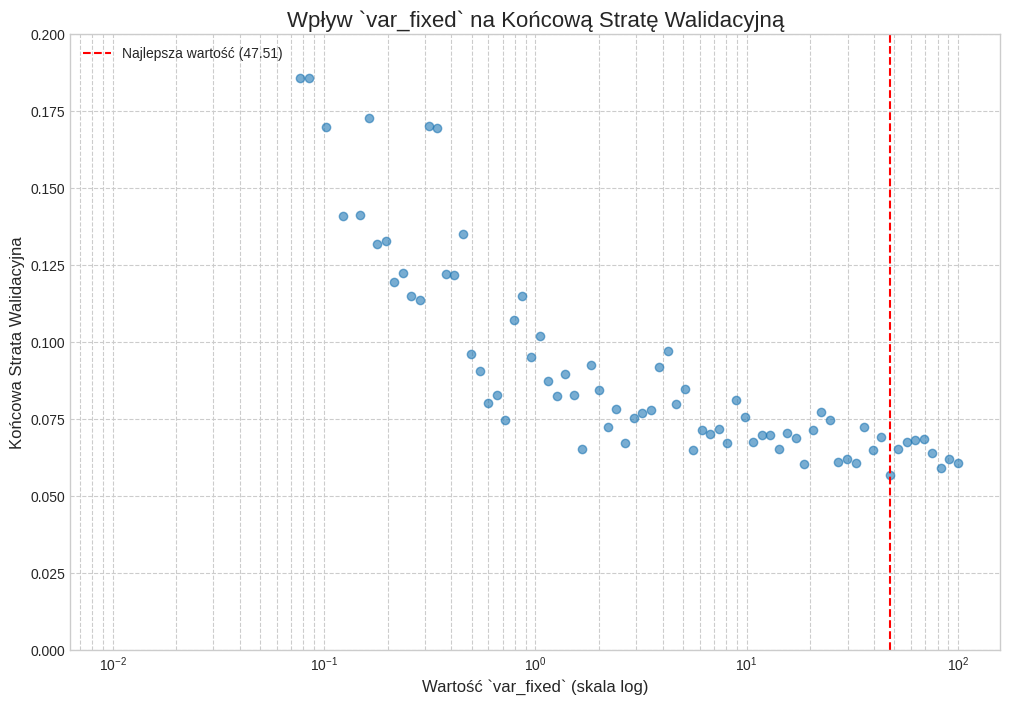

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
import numpy as np

# --- Konfiguracja (musi być identyczna jak w skrypcie treningowym) ---
EXPERIMENT_NAME = "dOGR_Grid_Search_var_clipping"
LOGGING_DIR = Path("logs")

param_grid = {
    'batch_size': [256],
    'var_fixed': np.logspace(-2, 2, 100).tolist()
}

experiments = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

def find_best_values_and_plot():
    """
    Przeszukuje logi, znajduje najlepsze wartości i tworzy wykres.
    """
    print(f"\n--- Analizowanie wyników z folderu: {LOGGING_DIR / EXPERIMENT_NAME} ---")
    
    results = []

    for config in experiments:
        batch_size = config['batch_size']
        var_fixed = config['var_fixed']
        
        var_fixed_str = f"var_fixed_{var_fixed:.2f}"
        version_name_float = f"bs_{batch_size}_var_fixed_{var_fixed_str}"
        path = LOGGING_DIR / EXPERIMENT_NAME / f"{version_name_float}" / "metrics.csv"
            
        try:
            df = pd.read_csv(path)
            final_val_loss_row = df[["epoch", "val_loss"]].dropna().iloc[-1]
            
            result = {
                "var_fixed": var_fixed,
                "val_loss": final_val_loss_row['val_loss']
            }
            results.append(result)
        except (pd.errors.EmptyDataError, IndexError):
            continue
    
    if not results:
        print("Nie znaleziono żadnych poprawnych plików z logami. Sprawdź nazwy folderów i EXPERIMENT_NAME.")
        return
    results_df = pd.DataFrame(results)
    
    best_run = results_df.loc[results_df['val_loss'].idxmin()]
    best_var = best_run['var_fixed']
    best_loss = best_run['val_loss']

    print("\n--- Analiza Zakończona ---")
    print(f"Znaleziono optymalną wartość var_fixed = {best_var:.4f}, która dała stratę walidacyjną = {best_loss:.4f}")

    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 8))
    
    plt.scatter(results_df['var_fixed'], results_df['val_loss'], alpha=0.6)
    plt.axvline(x=best_var, color='r', linestyle='--', label=f'Najlepsza wartość ({best_var:.2f})')
    
    plt.xscale('log') 
    plt.title("Wpływ `var_fixed` na Końcową Stratę Walidacyjną", fontsize=16)
    plt.xlabel("Wartość `var_fixed` (skala log)", fontsize=12)
    plt.ylabel("Końcowa Strata Walidacyjna", fontsize=12)
    plt.ylim(0, 0.2)
    plt.legend()
    plt.grid(True, which='both', linestyle="--")
    
    output_dir = LOGGING_DIR / EXPERIMENT_NAME / "summary_plots"
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_path = output_dir / "var_fixed_performance.png"
    plt.savefig(plot_path)
    print(f"Wykres analityczny zapisano w: {plot_path}")
    plt.show()

if __name__ == "__main__":
    find_best_values_and_plot()

## Porownanie ADAM i dOGR z var_fixed = 47.51

In [1]:
import os

os.chdir("..")


--- Generowanie wykresu porównawczego ---

--- Wyniki Końcowe ---

Wyniki dla 'dOGR_var_47.51':
  Końcowa Strata Testowa: 0.0863
  Końcowa Dokładność Testowa: 98.87%

Wyniki dla 'AdamW':
  Końcowa Strata Testowa: 0.0656
  Końcowa Dokładność Testowa: 99.16%

Wykres porównawczy zapisano w: logs/dOGR_vs_AdamW_Comparison/final_comparison_log_scale.png


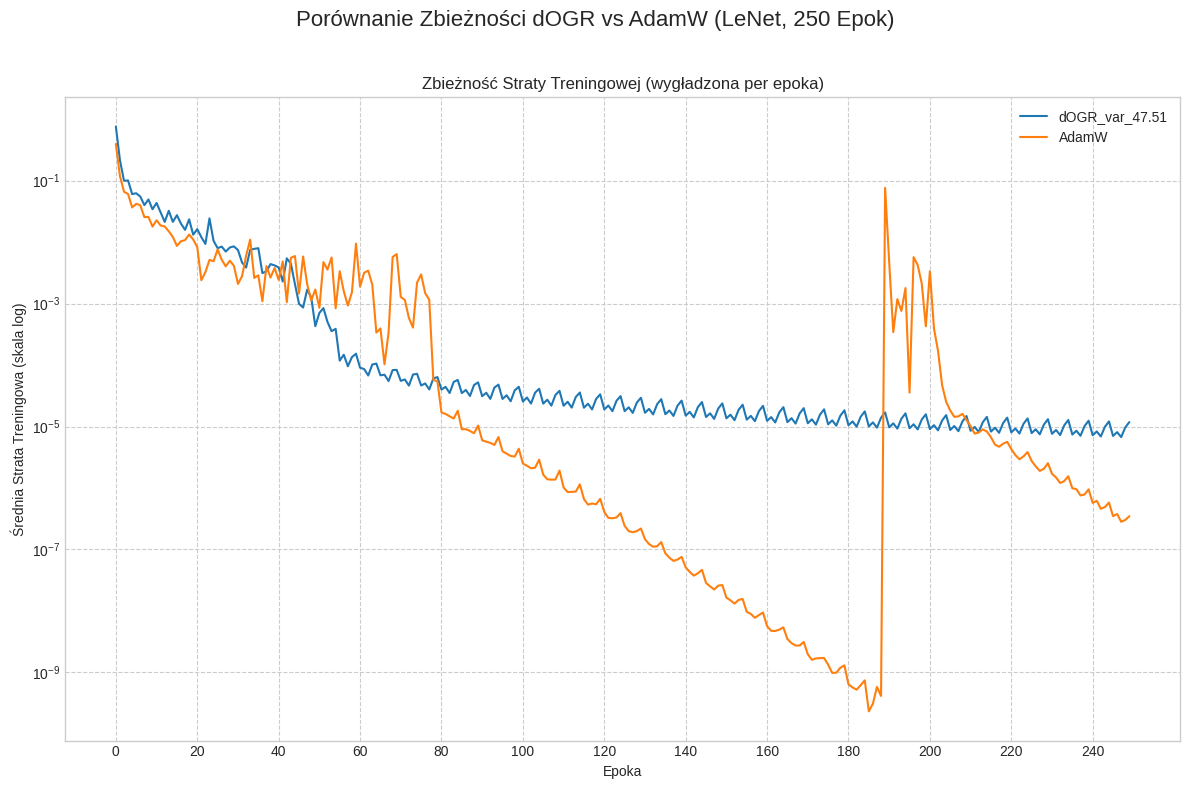

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch import optim
from tests.main import run, net_dict
from src.optim.dOGR import dOGR

# --- Konfiguracja Eksperymentu ---
EXPERIMENT_NAME = "dOGR_vs_AdamW_Comparison"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 250
BATCH_SIZE = 256
NET = "LeNet"
LEARNING_RATE = 1e-3

experiments = {
    "dOGR_var_47.51": {
        "opt": dOGR,
        "args": { 
            "lr": LEARNING_RATE, 
            "var_clipping": True,
            "var_fixed": 47.51,
            "beta": 0.1,
            "trust_factor": 1.0
        }
    },
    "AdamW": {
        "opt": optim.AdamW,
        "args": { "lr": LEARNING_RATE }
    }
}

def run_experiments():
    """Uruchamia oba zdefiniowane eksperymenty."""
    print(f"--- Uruchamianie {len(experiments)} eksperymentów ---")
    for i, (version_name, config) in enumerate(experiments.items()):
        print(f"\n[{i+1}/{len(experiments)}] Uruchamianie: {version_name}")
        
        torch.manual_seed(42)
        net = net_dict[NET]()
        optimizer = config["opt"](net.parameters(), **config["args"])
        
        run(
            net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
            version=version_name, max_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE
        )
    print("\n--- Wszystkie eksperymenty zakończone ---")

def plot_comparison():
    """Generuje jeden, ciągły wykres porównawczy dla straty treningowej."""
    print("\n--- Generowanie wykresu porównawczego ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(f"Porównanie Zbieżności dOGR vs AdamW ({NET}, {MAX_EPOCHS} Epok)", fontsize=16)

    print("\n--- Wyniki Końcowe ---")
    for name, config in experiments.items():
        path = LOGGING_DIR / EXPERIMENT_NAME / f"{name}" / "metrics.csv"
        if not path.exists():
            print(f"Nie znaleziono logów dla: {name}")
            continue
            
        df = pd.read_csv(path)
        
        train_loss_epoch = df[["epoch", "train_loss"]].dropna().groupby("epoch").mean().reset_index()

        ax.plot(train_loss_epoch["epoch"], train_loss_epoch["train_loss"], "-", label=name)

        test_df = df[["test_loss", "test_accuracy"]].dropna()
        if not test_df.empty:
            final_test_results = test_df.iloc[-1]
            print(f"\nWyniki dla '{name}':")
            print(f"  Końcowa Strata Testowa: {final_test_results['test_loss']:.4f}")
            print(f"  Końcowa Dokładność Testowa: {final_test_results['test_accuracy']:.2f}%")

    ax.set_title("Zbieżność Straty Treningowej (wygładzona per epoka)")
    ax.set_xlabel("Epoka")
    ax.set_ylabel("Średnia Strata Treningowa (skala log)")
    ax.set_yscale('log') 
    ax.legend()
    ax.grid(True, which='both', linestyle="--")

    plt.xticks(range(0, MAX_EPOCHS, 20))
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    output_dir = LOGGING_DIR / EXPERIMENT_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_path = output_dir / "final_comparison_log_scale.png"
    plt.savefig(plot_path)
    print(f"\nWykres porównawczy zapisano w: {plot_path}")
    
    plt.show()


if __name__ == "__main__":
    #run_experiments()
    plot_comparison()

In [1]:
import os

os.chdir("..")


--- Generowanie wykresu porównawczego ---

--- Wyniki Końcowe ---
logs/dOGR_vs_AdamW_Comparison/AdamW/metrics.csv

Wyniki dla 'dOGR_vs_AdamW_Comparison/AdamW':
  Końcowa Strata Testowa: 0.0656
  Końcowa Dokładność Testowa: 99.16%
logs/dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.10_trust_factor_1.00/metrics.csv

Wyniki dla 'dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.10_trust_factor_1.00':
  Końcowa Strata Testowa: 0.0574
  Końcowa Dokładność Testowa: 99.02%
logs/dOGR_vs_AdamW_Comparison/dOGR_var_47.51/metrics.csv

Wyniki dla 'dOGR_vs_AdamW_Comparison/dOGR_var_47.51':
  Końcowa Strata Testowa: 0.0863
  Końcowa Dokładność Testowa: 98.87%

Wykres porównawczy zapisano w: logs/dOGR_vs_AdamW_Comparison/final_comparison_log_scale.png


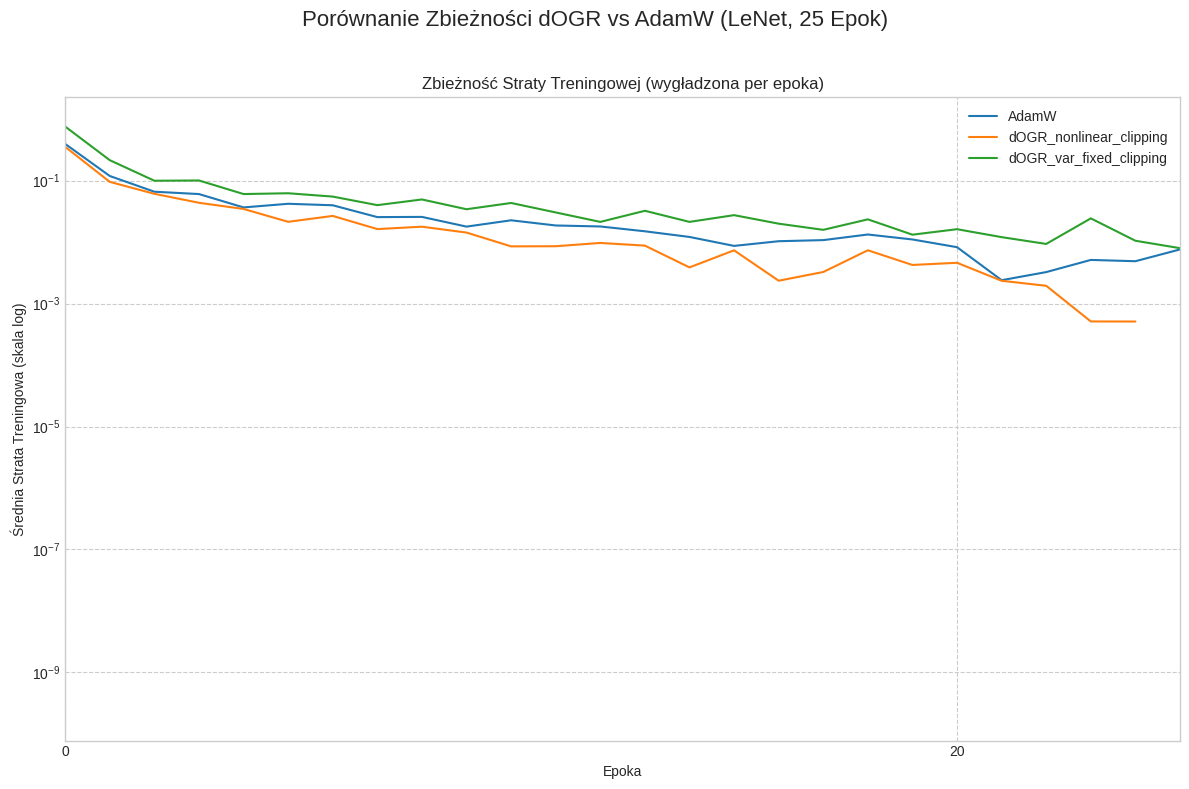

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch import optim

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

# --- Konfiguracja Eksperymentu ---
EXPERIMENT_NAME = "dOGR_vs_AdamW_Comparison"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 25
BATCH_SIZE = 256 
NET = "LeNet"
LEARNING_RATE = 1e-3

experiments = {
    "dOGR_vs_AdamW_Comparison/AdamW": {
        "name": "AdamW",
        "opt": optim.AdamW,
        "args": { "lr": LEARNING_RATE }
    },
    "dOGR_Grid_Search_nonlinear_clipping_tuning_parametrow/bs_64_p_norm_0.57_p_eps_10.77_beta_0.10_trust_factor_1.00": {
        "name": "dOGR_nonlinear_clipping",
        "opt": dOGR,
        "args": {
            "lr": LEARNING_RATE,
            "nonlinear_clipping": True,
            "p_norm": 0.57,
            "p_eps": 10.77,
            "beta": 0.1,
            "trust_factor": 1.0
        }
    },
    "dOGR_vs_AdamW_Comparison/dOGR_var_47.51": {
        "name": "dOGR_var_fixed_clipping",
        "opt": dOGR,
        "args": {
            "lr": LEARNING_RATE,
            "var_clipping": True,
            "var_fixed": 47.51,
            "beta": 0.1,
            "trust_factor": 1.0
        }
    }
}

def plot_comparison():
    """Generuje jeden, ciągły wykres porównawczy dla straty treningowej."""
    print("\n--- Generowanie wykresu porównawczego ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(f"Porównanie Zbieżności dOGR vs AdamW ({NET}, {MAX_EPOCHS} Epok)", fontsize=16)

    print("\n--- Wyniki Końcowe ---")
    for name, config in experiments.items():
        path = LOGGING_DIR / f"{name}" / "metrics.csv"
        print(path)
        if not path.exists():
            print(f"Nie znaleziono logów dla: {name}")
            continue
            
        df = pd.read_csv(path)
        
        train_loss_epoch = df[["epoch", "train_loss"]].dropna().groupby("epoch").mean().reset_index()

        label = config["name"]

        ax.plot(train_loss_epoch["epoch"], train_loss_epoch["train_loss"], "-", label=label)

        test_df = df[["test_loss", "test_accuracy"]].dropna()
        if not test_df.empty:
            final_test_results = test_df.iloc[-1]
            print(f"\nWyniki dla '{name}':")
            print(f"  Końcowa Strata Testowa: {final_test_results['test_loss']:.4f}")
            print(f"  Końcowa Dokładność Testowa: {final_test_results['test_accuracy']:.2f}%")

    ax.set_title("Zbieżność Straty Treningowej (wygładzona per epoka)")
    ax.set_xlabel("Epoka")
    ax.set_ylabel("Średnia Strata Treningowa (skala log)")
    ax.set_yscale('log') 
    ax.set_xlim(0, MAX_EPOCHS)  
    ax.legend()
    ax.grid(True, which='both', linestyle="--")

    plt.xticks(range(0, MAX_EPOCHS, 20))
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    output_dir = LOGGING_DIR / EXPERIMENT_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_path = output_dir / "final_comparison_log_scale.png"
    plt.savefig(plot_path)
    print(f"\nWykres porównawczy zapisano w: {plot_path}")
    
    plt.show()


if __name__ == "__main__":
    #run_experiments()
    plot_comparison()

### Na powyzszym wykresie widac ze dOGR z nonlinear clippingiem i fine tuiningiem wartosci wypada lepiej niz AdamW, przynajmniej po 25 epokach. Ponizej sprawdzam co sie stanie jestli wytrenujemy oba modele przez 500 epoch. Problem powyzszego wykresu jest tylko taki ze AdamW i dOGR_var_fixed_clipping były trenowane na batch size = 256, a dOGR_nonlinear_clipping na batch size = 64. Zobaczymy jak to wplynie na wyniki, bo ponizej testuje oba optymalizatory z batch size = 256

In [2]:
import os

os.chdir("..")


--- Generowanie wykresu porównawczego ---

--- Wyniki Końcowe ---

Wyniki dla 'dOGR_nonlinear_clipping':
  Końcowa Strata Testowa: 0.0781
  Końcowa Dokładność Testowa: 99.03%

Wyniki dla 'AdamW':
  Końcowa Strata Testowa: 0.0533
  Końcowa Dokładność Testowa: 99.19%

Wyniki dla 'dOGR_vs_AdamW_Comparison/dOGR_var_47.51':
  Końcowa Strata Testowa: 0.0863
  Końcowa Dokładność Testowa: 98.87%

Wykres porównawczy zapisano w: logs/dOGR_nonlinear_clipping_vs_AdamW_Comparison/final_comparison_log_scale_250epoch.png


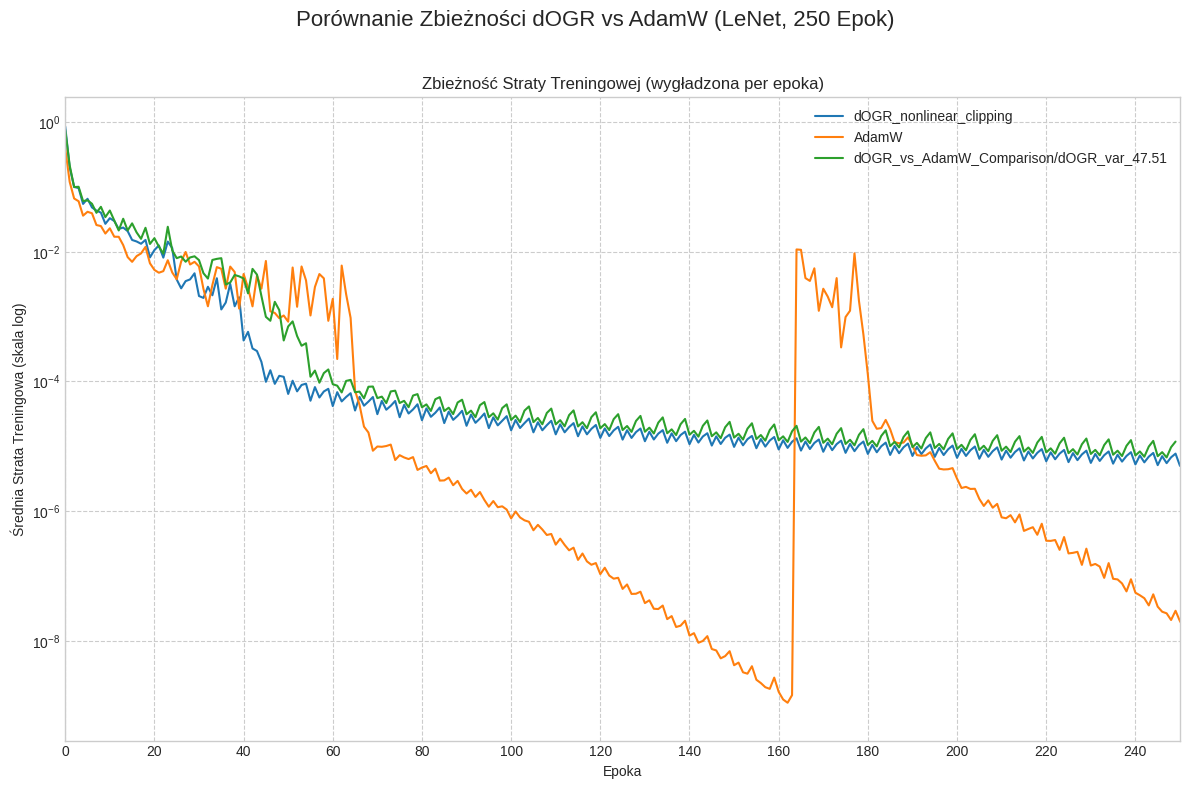

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from torch import optim

from tests.main import run, net_dict
from src.optim.dOGR import dOGR

# --- Konfiguracja Eksperymentu ---
EXPERIMENT_NAME = "dOGR_nonlinear_clipping_vs_AdamW_Comparison"
LOGGING_DIR = Path("logs")
MAX_EPOCHS = 250
BATCH_SIZE = 256 
NET = "LeNet"
LEARNING_RATE = 1e-3

# --- Definicja eksperymentów do porównania ---
experiments = {
    "dOGR_nonlinear_clipping": {
        "opt": dOGR,
        "args": {
            "lr": LEARNING_RATE,
            "nonlinear_clipping": True,
            "p_norm": 0.57,
            "p_eps": 10.77,
            "beta": 0.1,
            "trust_factor": 1.0
        }
    },
    "AdamW": {
        "opt": optim.AdamW,
        "args": { "lr": LEARNING_RATE }
    },
    "dOGR_vs_AdamW_Comparison/dOGR_var_47.51": {
        "name": "dOGR_var_fixed_clipping",
        "opt": dOGR,
        "args": {
            "lr": LEARNING_RATE,
            "var_clipping": True,
            "var_fixed": 47.51,
            "beta": 0.1,
            "trust_factor": 1.0
        }
    }
}

def run_experiments():
    """Uruchamia oba zdefiniowane eksperymenty."""
    print(f"--- Uruchamianie {len(experiments)} eksperymentów ---")
    for i, (version_name, config) in enumerate(experiments.items()):
        print(f"\n[{i+1}/{len(experiments)}] Uruchamianie: {version_name}")
        
        torch.manual_seed(42)
        net = net_dict[NET]()
        optimizer = config["opt"](net.parameters(), **config["args"])
        
        run(
            net=net, optimizer=optimizer, name=EXPERIMENT_NAME,
            version=version_name, max_epochs=MAX_EPOCHS, batch_size=BATCH_SIZE
        )
    print("\n--- Wszystkie eksperymenty zakończone ---")

def plot_comparison():
    """Generuje jeden, ciągły wykres porównawczy dla straty treningowej."""
    print("\n--- Generowanie wykresu porównawczego ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(f"Porównanie Zbieżności dOGR vs AdamW ({NET}, {MAX_EPOCHS} Epok)", fontsize=16)

    print("\n--- Wyniki Końcowe ---")
    for name, config in experiments.items():
        if name == "dOGR_vs_AdamW_Comparison/dOGR_var_47.51":
            path = LOGGING_DIR / "dOGR_vs_AdamW_Comparison/dOGR_var_47.51" / "metrics.csv"
        else:
            path = LOGGING_DIR / EXPERIMENT_NAME / f"{name}" / "metrics.csv"
        if not path.exists():
            print(f"Nie znaleziono logów dla: {name}")
            continue
            
        df = pd.read_csv(path)
        
        train_loss_epoch = df[["epoch", "train_loss"]].dropna().groupby("epoch").mean().reset_index()

        ax.plot(train_loss_epoch["epoch"], train_loss_epoch["train_loss"], "-", label=name)

        test_df = df[["test_loss", "test_accuracy"]].dropna()
        if not test_df.empty:
            final_test_results = test_df.iloc[-1]
            print(f"\nWyniki dla '{name}':")
            print(f"  Końcowa Strata Testowa: {final_test_results['test_loss']:.4f}")
            print(f"  Końcowa Dokładność Testowa: {final_test_results['test_accuracy']:.2f}%")

    ax.set_title("Zbieżność Straty Treningowej (wygładzona per epoka)")
    ax.set_xlabel("Epoka")
    ax.set_xlim([0, MAX_EPOCHS])
    ax.set_ylabel("Średnia Strata Treningowa (skala log)")
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, which='both', linestyle="--")

    plt.xticks(range(0, MAX_EPOCHS, 20))
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    output_dir = LOGGING_DIR / EXPERIMENT_NAME
    output_dir.mkdir(parents=True, exist_ok=True)
    plot_path = output_dir / "final_comparison_log_scale_250epoch.png"
    plt.savefig(plot_path)
    print(f"\nWykres porównawczy zapisano w: {plot_path}")
    
    plt.show()


if __name__ == "__main__":
    # run_experiments()
    plot_comparison()